<a href="https://colab.research.google.com/github/lee-yeonji/DA_project1_personal/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D%ED%8C%8C%EC%9D%BC(step2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#K-Means
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

--- 폰트 파일 'NanumGothic-Regular.ttf'이(가) 이미 존재합니다. ---
✅ 폰트 설정 완료! 폰트 이름: NanumGothic
이제부터 한글 시각화가 정상적으로 작동합니다.


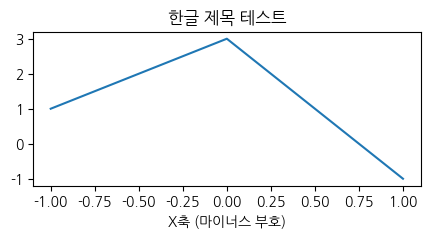

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import requests # 폰트 다운로드를 위해 requests 임포트

# 0. 다운로드할 폰트 파일 이름 및 URL
font_filename = 'NanumGothic-Regular.ttf'
# (구글 폰트 GitHub 저장소의 원본 파일 URL)
font_url = 'https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf'

# --- 1. (★수정됨) 파일이 없으면 '자동 다운로드' ---
if not os.path.exists(font_filename):
    print("--- 폰트 파일이 없습니다. 다운로드를 시작합니다. ---")
    try:
        # 1-1. GitHub에서 폰트 파일 다운로드
        response = requests.get(font_url)
        response.raise_for_status() # 오류가 있으면 예외 발생

        with open(font_filename, 'wb') as f:
            f.write(response.content)

        print(f"--- '{font_filename}' 다운로드 완료 ---")

    except requests.exceptions.RequestException as e:
        print(f"--- [오류] 폰트 다운로드 실패: {e} ---")
        font_filename = None # 실패 시
else:
    print(f"--- 폰트 파일 '{font_filename}'이(가) 이미 존재합니다. ---")

# --- 2. (★수정됨) 폰트 설정 ---
# (파일이 성공적으로 준비되었을 때만 폰트 설정을 진행)
if font_filename and os.path.exists(font_filename):
    try:
        # 2-1. 폰트 매니저에 폰트 추가 (★중요: 런타임마다 실행되어야 함)
        fm.fontManager.addfont(font_filename)

        # 2-2. 폰트 속성 로드 및 이름 확인
        font_prop = fm.FontProperties(fname=font_filename)
        font_name = font_prop.get_name()

        # 2-3. Matplotlib 기본 폰트 및 마이너스 부호 설정
        plt.rcParams['font.family'] = font_name
        plt.rcParams['axes.unicode_minus'] = False

        print(f"✅ 폰트 설정 완료! 폰트 이름: {font_name}")
        print("이제부터 한글 시각화가 정상적으로 작동합니다.")

        # 2-4. 테스트 시각화 (확인용)
        plt.figure(figsize=(5, 2))
        plt.plot([-1, 0, 1], [1, 3, -1])
        plt.title('한글 제목 테스트') # rcParams로 자동 적용됨
        plt.xlabel('X축 (마이너스 부호)')
        plt.show()

    except Exception as e:
        print(f"--- [오류] 폰트 설정 실패: {e} ---")
        print("런타임을 다시 시작하고 이 셀을 재실행해 보세요.")
else:
    print("--- 폰트 파일이 준비되지 않아 설정을 건너뜁니다. ---")

In [ ]:
leisure_path = '/content/gdrive/MyDrive/데이터분석 학습 및 실습/공모전-2025문화체육관광통계데이터/leisure_activities.csv'
culture_path = '/content/gdrive/MyDrive/데이터분석 학습 및 실습/공모전-2025문화체육관광통계데이터/culture_activities.csv'

df_leisure = pd.read_csv(leisure_path)
df_culture = pd.read_csv(culture_path)

#### 데이터 준비: 분석용 컬럼 목록 추출 후 데이터프레임 재생성

1. df_leusure(여가조사) '분석용 컬럼' 목록 추출

In [ ]:
# 1. 인구 통계 변수
leisure_demo_cols = [
    '응답자 ID',
    '나이',
    '성별',
    '지난 1년 간 세금 공제 전 월 평균 소득- 가구',
    '본인의 교육정도 - 최종학력',
    '시도권역',
    '시부군부 유형',
    '주택유형',
    '응답자 성별',
    '혼인상태',
    '주당 평균 근무 시간'
]

# 2. 핵심 변수 (동반자, 만족도)
leisure_core_cols = [
    '지난 1년간 가장 많이 참여한 여가활동 동반자(1순위)', # 'Solo' 그룹 정의
    '전반적 여가생활 만족도',                     # 핵심 Y
    '지난 1년간 가장 많이 참여한 여가활동 만족도(1순위)', # 보조 Y
    '생활권 내 공공 문화여가시설 만족도',             # 보조 Y
    '민간 여가산업 만족도- 여가 관련 공간산업',       # 보조 Y
    '민간 여가산업 만족도- 여가 관련 용품산업',       # 보조 Y
    '민간 여가산업 만족도- 여가 관련 서비스산업'      # 보조 Y
]

# 3. '제약요인' 컬럼 (접두사로 자동 추출)
leisure_cause_cols = [col for col in df_leisure.columns if col.startswith('여가활동 제약요인 - ')]

# 4. '참여활동' 컬럼 (접두사로 자동 추출)
leisure_participation_cols = [col for col in df_leisure.columns if col.startswith('한 번 이상 참여한 여가활동 - ')]

# 5. 분석 후 추가 컬럼
leisure_additional_cols = [
    # 표본 가중치
    '[생성] 가중치',

    # 여가 시간 관련
    '지난 1년 간 여가시간 자유도 - 평일',
    '지난 1년 간 여가시간 자유도 - 휴일',

    # 여가시설 접근성 및 환경
    '생활권 내 공공문화 및 여가시설 이용 충분도',

    # 행복 및 인식 변수
    '현재 행복 수준(0~10점: 11점 척도)',

    # 근무형태/유연근무 관련
    '유연근무제 시행 여부',

    # 활동 내용
    '지난 1년간 가장 많이 참여한 여가활동 (1순위)',

    # 상태 인식
    '본인의 사회적 관계(고립감, 외로움 등) 인식',
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식',
    '본인의 신체 건강상태 인식',
    '응답자 장애등록 여부',

    # Cluster 0의 "미충족 수요" 증명
    '향후 희망하는 여가활동(1순위)',
    '집 외 가장 많이 이용하고 싶은 여가공간 (1순위)',

    # 고립 상태 증명용
    '지난 1년간 여가활동을 위한 동호회 참여 여부'

]

# 6. 위 목록을 모두 합치기 ('실제 파일에 있는 컬럼'만 골라서 최종 리스트 만들기)
leisure_cols = leisure_demo_cols + leisure_core_cols + leisure_cause_cols + leisure_participation_cols + leisure_additional_cols

unique_leisure_cols = list(dict.fromkeys(leisure_cols))

actual_leisure_cols_set = set(df_leisure.columns)
leisure_cols_fin = [col for col in unique_leisure_cols if col in actual_leisure_cols_set]

2. df_culture(문화예술활동) '분석용 컬럼' 목록 추출

In [ ]:
# 1. 인구통계 컬럼
culture_demo_cols = [
    'pid',
    '시부군부 유형',
    '시도권역구분_코드',
    '주택유형',
    '성별 (Q22)',
    '나이',
    '최종학력',
    '혼인 상태',
    '세금 공제 전 월평균 가구 소득',
    '근무형태 (Q30_4)'
]

# 2. 핵심 변수 컬럼
culture_core_cols = [col for col in df_culture.columns if col.startswith('문화예술행사(직접관람)_관람걸림돌')]

# 3. 파생 변수 컬럼: 문화 미관람 집단을 정의하기 위함
culture_counts_cols = [col for col in df_culture.columns if '직접관람 횟수' in col]

# 4. 분석 후 추가 컬럼
culture_want_cols = [col for col in df_culture.columns if col.startswith('향후 1년 이내 직접관람 의향_복수응답')]
culture_cost_cols = [
    '문화예술활동 월평균 합계 <총 합계>',
    '문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)',
]
culture_state_cols = [
    # 상태 인식
    '본인의 사회적 관계(고립감, 외로움 등) 인식',
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식',
    '본인의 신체 건강상태 인식',
    '장애등록 여부 (Q25)'
]

# 4-1. 분석 후 만족도 추가
# 각 컬럼 그룹별 리스트 생성
cols_direct_viewing = [col for col in df_culture.columns if '직접관람 만족도' in col]
cols_participation = [col for col in df_culture.columns if col.startswith('문화예술활동 참여만족도')]
cols_education = [col for col in df_culture.columns if col.startswith('문화예술교육 경험 만족도')] # <-- 오타 수정
cols_space_env = [col for col in df_culture.columns if col.startswith('문화예술활동 공간 및 환경에 대한 만족도')]

# 모든 리스트를 하나의 최종 리스트로 통합 (평탄화)
culture_satis_cols = cols_direct_viewing + cols_participation + cols_education + cols_space_env

# 4-2. 클러스터 분석 이후 추가 (리스트 평탄화)
cols_companion = [col for col in df_culture.columns if col.startswith('문화예술행사 직접관람 관람동행자 ')]
cols_hobby_club = [col for col in df_culture.columns if col.startswith('문화관련 동호회 참여 경험_복수응답')]

culture_cluster_cols = [
    # "시간 제약" 교차 검증용
    '문화예술행사 향유 시간적 여건',
    '문화예술행사 직접관람 희망 시간대',
] + cols_companion + cols_hobby_club

# 5. 위 목록을 모두 합치고, 실제 파일에 있는 컬럼만 최종 선별
culture_cols = culture_demo_cols + culture_core_cols + culture_counts_cols + culture_want_cols + culture_cost_cols + culture_state_cols + culture_satis_cols + culture_cluster_cols

unique_culture_cols = list(dict.fromkeys(culture_cols))

actual_culture_cols_set = set(df_culture.columns)
culture_cols_fin = [col for col in unique_culture_cols if col in actual_culture_cols_set]

3. 분석용 칼럼 목록 맞춤 데이터프레임 생성 확인

- 메인 데이터: 여가활동(: `leisure`)

In [ ]:
leisure = df_leisure[leisure_cols_fin].copy()
leisure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Columns: 132 entries, 응답자 ID to 지난 1년간 여가활동을 위한 동호회 참여 여부
dtypes: float64(1), int64(2), object(129)
memory usage: 10.1+ MB


- 보조 데이터: 문화예술활동(: `culture`)

In [ ]:
culture = df_culture[culture_cols_fin].copy()
culture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 98 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   pid                                              10103 non-null  int64 
 1   시부군부 유형                                          10103 non-null  object
 2   시도권역구분_코드                                        10103 non-null  object
 3   주택유형                                             10103 non-null  object
 4   성별 (Q22)                                         10103 non-null  object
 5   나이                                               10103 non-null  int64 
 6   최종학력                                             10103 non-null  object
 7   혼인 상태                                            10103 non-null  object
 8   세금 공제 전 월평균 가구 소득                                10103 non-null  object
 9   근무형태 (Q30_4)                           

#### 데이터 클리닝

##### 0. 결측치 확인

In [ ]:
print(leisure.isna().sum())

응답자 ID                          0
나이                              0
성별                              0
지난 1년 간 세금 공제 전 월 평균 소득- 가구     0
본인의 교육정도 - 최종학력                 0
                               ..
본인의 신체 건강상태 인식                  0
응답자 장애등록 여부                     0
향후 희망하는 여가활동(1순위)               0
집 외 가장 많이 이용하고 싶은 여가공간 (1순위)    0
지난 1년간 여가활동을 위한 동호회 참여 여부       0
Length: 132, dtype: int64


In [ ]:
print(culture.isna().sum())

pid                              0
시부군부 유형                          0
시도권역구분_코드                        0
주택유형                             0
성별 (Q22)                         0
                                ..
문화관련 동호회 참여 경험_복수응답 <연극>         0
문화관련 동호회 참여 경험_복수응답 <뮤지컬>        0
문화관련 동호회 참여 경험_복수응답 <무용>         0
문화관련 동호회 참여 경험_복수응답 <영화>         0
문화관련 동호회 참여 경험_복수응답 <대중음악/연예>    0
Length: 98, dtype: int64


'결측치가 없다'고 나오는 이유: 결측치들이 아직 `NaN`이 아니라 '텍스트'로 위장하고 있기 때문
- '나이'나 '소득' 컬럼 안에 '모름/무응답', '99', ' '(빈칸) 같은 글자가 들어있음
<br> => 위장된 결측치를 표준 결측치로 바꾸기

##### 1. 메인 분석용 데이터(leisure) 클리닝

In [ ]:
leisure = leisure.drop(columns=['응답자 성별'], axis=1)

1-1. leisure(컬럼118개) 클리닝

###### 내용 확인

In [ ]:
leisure['지난 1년간 가장 많이 참여한 여가활동 만족도(1순위)'].unique()

array(['만족한다', '보통이다', '매우 만족한다', '다소 만족한다', '다소 불만족한다', '불만족한다',
       '매우 불만족한다'], dtype=object)

In [ ]:
leisure['생활권 내 공공 문화여가시설 만족도'].unique()

array([' ', '다소 만족한다', '매우 만족한다', '보통이다', '불만족한다', '만족한다', '다소 불만족한다',
       '매우 불만족한다'], dtype=object)

In [ ]:
leisure['지난 1년 간 여가시간 자유도 - 평일'].unique()

array(['매우 자유롭다', '다소 자유롭다', '자유롭다', '보통이다', '다소 자유롭지 않았다', '자유롭지 않았다',
       '전혀 자유롭지 않았다'], dtype=object)

In [ ]:
leisure['지난 1년 간 여가시간 자유도 - 휴일'].unique()

array(['매우 자유롭다', '보통이다', '자유롭다', '다소 자유롭다', '자유롭지 않았다', '다소 자유롭지 않았다',
       '전혀 자유롭지 않았다'], dtype=object)

In [ ]:
leisure['생활권 내 공공문화 및 여가시설 이용 충분도'].unique()

array(['전혀 그렇지 않다', '보통이다', '그렇지 않다', '다소 그렇다', '그렇다', '다소 그렇지 않다',
       '매우 그렇다'], dtype=object)

In [ ]:
leisure['현재 행복 수준(0~10점: 11점 척도)'].unique()

array(['3', '5 보통', '9', '6', '8', '7', '4', '2', '매우 행복', '1', '매우 불행'],
      dtype=object)

In [ ]:
leisure['유연근무제 시행 여부'].unique()

array([' ', '해당 없음', '예', '아니오'], dtype=object)

In [ ]:
leisure['본인의 사회적 관계(고립감, 외로움 등) 인식'].unique()

array(['보통', '5', '3', '2', '6', '고립감, 외로움을 거의 느끼지 않는다',
       '고립감, 외로움을 대단히 많이 느낀다'], dtype=object)

In [ ]:
leisure['본인의 정신(스트레스, 우울감 등) 건강상태 인식'].unique()

array(['전혀 건강하지 않음', '6', '3', '보통', '5', '2', '매우 건강함'], dtype=object)

In [ ]:
leisure['본인의 신체 건강상태 인식'].unique()

array(['전혀 건강하지 않음', '6', '보통', '매우 건강함', '5', '3', '2'], dtype=object)

In [ ]:
leisure['응답자 장애등록 여부'].unique()

array(['해당사항 없음', '장애등록', '미등록'], dtype=object)

###### 전처리 진행

In [ ]:
# 1. '만족도' 변환 규칙 (7점 척도)
satisfaction_map = {
    '매우 불만족한다': 1,
    '불만족한다': 2,
    '다소 불만족한다': 3,
    '보통이다': 4,
    '다소 만족한다': 5,
    '만족한다': 6,
    '매우 만족한다': 7,
    '모름/무응답': np.nan,
    ' ': np.nan,
    np.nan: np.nan
}
satisfaction_cols = [
    '전반적 여가생활 만족도', '지난 1년간 가장 많이 참여한 여가활동 만족도(1순위)', '생활권 내 공공 문화여가시설 만족도',
    '민간 여가산업 만족도- 여가 관련 공간산업', '민간 여가산업 만족도- 여가 관련 용품산업', '민간 여가산업 만족도- 여가 관련 서비스산업'
]

for col in satisfaction_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(satisfaction_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 2. '여가활동 제약 요인' 변환 규칙
influence_map = {
    '전혀 영향을 끼치지 않는다': 1,
    '영향을 끼치지 않는다': 2,
    '다소 영향을 끼치지 않는다': 3,
    '보통이다': 4,
    '다소 영향을 끼친다': 5,
    '영향을 끼친다': 6,
    '매우 영향을 끼친다': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
influence_cols = [
    '여가활동 제약요인 - 시간부족',
    '여가활동 제약요인 - 경제적 지출 부담',
    '여가활동 제약요인 - 여가활동 경험 부족',
    '여가활동 제약요인 - 여가 정보 부족',
    '여가활동 제약요인 - 질병 및 장애(본인, 가족 포함)',
    '여가활동 제약요인 - 여가 동반자 없음',
    '여가활동 제약요인 - 여가시설 접근성 부족',
    '여가활동 제약요인 - 여가프로그램 부족',
    '여가활동 제약요인 - 기후 여건(미세먼지, 폭염 등)'
]

for col in influence_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(influence_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 3. '여가시간 자유도' 변환 규칙
time_free_map = {
    '전혀 자유롭지 않았다': 1,
    '자유롭지 않았다': 2,
    '다소 자유롭지 않았다': 3,
    '보통이다': 4,
    '다소 자유롭다': 5,
    '자유롭다': 6,
    '매우 자유롭다': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
time_free_cols = [
    '지난 1년 간 여가시간 자유도 - 평일',
    '지난 1년 간 여가시간 자유도 - 휴일'
]

for col in time_free_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(time_free_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 4. '여가 공간 이용 충분도' 변환 규칙
good_place_map = {
    '전혀 그렇지 않다': 1,
    '그렇지 않다': 2,
    '다소 그렇지 않다': 3,
    '보통이다': 4,
    '다소 그렇다': 5,
    '그렇다': 6,
    '매우 그렇다': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
good_place_cols = [
    '생활권 내 공공문화 및 여가시설 이용 충분도'
]

for col in good_place_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(good_place_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 5. '현재 행복 수준' 변환 규칙
now_happy_map = {
    '매우 불행': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5 보통': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '매우 행복': 10,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
now_happy_cols = [
    '현재 행복 수준(0~10점: 11점 척도)'
]

for col in now_happy_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(now_happy_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 6. '유연근무제 시행 여부' 변환 규칙
work_time_map = {
    '예': 1,
    '아니오': 0,
    '해당 없음': 0,
    ' ': 0,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
work_time_cols = [
    '유연근무제 시행 여부'
]

for col in work_time_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(work_time_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

In [ ]:
# 7. '사회적 관계 인식' 변환 규칙
lonely_map = {
    '고립감, 외로움을 거의 느끼지 않는다': 1,
    '2': 2,
    '3': 3,
    '보통': 4,
    '5': 5,
    '6': 6,
    '고립감, 외로움을 대단히 많이 느낀다': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
lonely_cols = [
    '본인의 사회적 관계(고립감, 외로움 등) 인식'
]

for col in lonely_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(lonely_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 8. '건강 인식' 변환 규칙
health_map = {
    '전혀 건강하지 않음': 1,
    '2': 2,
    '3': 3,
    '보통': 4,
    '5': 5,
    '6': 6,
    '매우 건강함': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
health_cols = [
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식',
    '본인의 신체 건강상태 인식'
]

for col in health_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(health_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

# 9. '장애 여부# 9. '장애 여부' 변환 규칙
obstacle_map = {
    '해당사항 없음': 0,
    '미등록': 0,
    '장애등록': 1,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
obstacle_cols = [
    '응답자 장애등록 여부'
]

for col in obstacle_cols:
  if col in leisure.columns:
    leisure[col] = leisure[col].map(obstacle_map)

    median_val = leisure[col].median()
    leisure[col] = leisure[col].fillna(median_val)
    leisure[col] = leisure[col].astype('float32')

In [ ]:
# (1. to_one 함수 정의)
def to_one(x):
    if pd.isna(x):
        return 0
    s = str(x).strip()
    # [★필수 수정★] '의향있음'이 아니라 '참여' 토큰을 찾아야 합니다.
    if s in {'참여','예','Y','y','1','TRUE','True','true'}:
        return 1
    if s in {'미참여','아니오','N','n','0','FALSE','False','false'}:
        return 0
    try:
        return 1 if float(s) == 1.0 else 0
    except Exception:
        return 0

# (2. 91개 컬럼 리스트 생성)
leisure_participation_cols = [col for col in leisure.columns if col.startswith('한 번 이상 참여한 여가활동 - ')]

# (3. 91개 컬럼 0/1로 청소
if leisure_participation_cols:
    leisure.loc[:, leisure_participation_cols] = (
        leisure[leisure_participation_cols].map(to_one).astype('int8')
    )
    leisure['여가활동 참여 총횟수'] = (
        leisure[leisure_participation_cols].sum(axis=1).astype('int16')
    )
else:
    leisure['여가활동 참여 총횟수'] = 0

leisure = leisure.copy()

# ---. '동호회 참여 여부' 변환 규칙 (10번째 전처리) ---

# 10-1. 변환 규칙 정의
club_participation_map = {
    '예': 1,
    '아니오': 0,
    '모름/무응답': np.nan, # 결측치로 우선 처리
    np.nan: np.nan
}

club_col = '지난 1년간 여가활동을 위한 동호회 참여 여부'

if club_col in leisure.columns:
    # 10-2. 텍스트를 숫자로 매핑
    leisure[club_col] = leisure[club_col].map(club_participation_map)

    # 10-3. 결측치를 0 (미참여)으로 채우기 (보수적 처리)
    # (동호회 참여 안 한 사람과 응답 안 한 사람을 '미참여'로 동일하게 간주)
    leisure[club_col] = leisure[club_col].fillna(0).astype('int8') # int8로 타입 변경

In [ ]:
leisure['지난 1년 간 세금 공제 전 월 평균 소득- 가구'].unique()

array(['월 평균 100만원 미만', '월 평균 400만원 ~ 500만원 미만', '월 평균 600만원 ~ 700만원 미만',
       '월 평균 100만원 ~ 200만원 미만', '월 평균 500만원 ~ 600만원 미만',
       '월 평균 300만원 ~ 400만원 미만', '월 평균 200만원 ~ 300만원 미만', '소득없음',
       '월 평균 1,000만원 이상', '월 평균 700만원 ~ 800만원 미만',
       '월 평균 900만원 ~ 1,000만원 미만', '월 평균 800만원 ~ 900만원 미만'], dtype=object)

In [ ]:
# 3. '지난 1년 간 세금 공제 전 월 평균 소득- 가구' 컬럼 변환
from scipy.stats.mstats import winsorize
import pandas as pd
import numpy as np

income_map = {
    '소득없음': 0,
    '월 평균 100만원 미만': 50,
    '월 평균 100만원 ~ 200만원 미만': 150,
    '월 평균 200만원 ~ 300만원 미만': 250,
    '월 평균 300만원 ~ 400만원 미만': 350,
    '월 평균 400만원 ~ 500만원 미만': 450,
    '월 평균 500만원 ~ 600만원 미만': 550,
    '월 평균 600만원 ~ 700만원 미만': 650,
    '월 평균 700만원 ~ 800만원 미만': 750,
    '월 평균 800만원 ~ 900만원 미만': 850,
    '월 평균 900만원 ~ 1,000만원 미만': 950,
    '월 평균 1,000만원 이상': 1000,
    np.nan: np.nan
}
income_col_leisure = '지난 1년 간 세금 공제 전 월 평균 소득- 가구'

if income_col_leisure in leisure.columns:
  leisure['소득_가구'] = leisure[income_col_leisure].map(income_map)

  median_val = leisure['소득_가구'].median()
  leisure['소득_가구'] = leisure['소득_가구'].fillna(median_val)

  # 'NaN이 없는' 깨끗한 '소득_가구' 컬럼에 'Winsorize' 적용
  leisure['소득_가구'] = winsorize(leisure['소득_가구'], limits=[0.01, 0.01])

  # '지난 1년 간 세금 공제 전 월 평균 소득- 가구' 컬럼 삭제
  leisure = leisure.drop(columns=[income_col_leisure])

In [ ]:
leisure['주당 평균 근무 시간'].unique()

array([' ', '60', '40', '52', '30', '20', '9', '48', '45', '50', '58',
       '15', '55', '18', '72', '44', '8', '6', '24', '42', '35', '36',
       '56', '10', '3', '38', '25', '2', '32', '11', '54', '7', '84', '5',
       '63', '70', '12', '4', '28', '80', '66', '49', '16', '62', '14',
       '46', '43', '65', '75', '1', '13', '78', '90', '53', '34', '64',
       '57', '21', '59', '81', '105', '115', '17'], dtype=object)

In [ ]:
# 1. '주당 평균 근무 시간' 데이터 전처리
work_hours_col = '주당 평균 근무 시간'
new_col_work = '주당_평균_근무시간'

if work_hours_col in leisure.columns:
  leisure[new_col_work] = leisure[work_hours_col].replace(' ', 0)
  leisure[new_col_work] = pd.to_numeric(leisure[new_col_work], errors='coerce')
  leisure[new_col_work] = leisure[new_col_work].fillna(0)
  leisure[new_col_work] = leisure[new_col_work].astype(int)

# 2. K-Means 모델 입력용
realistic_max_hours = 80
kmeans_input_col = '주당_평균_근무시간_kmeans'

leisure[kmeans_input_col] = leisure[new_col_work].clip(upper=realistic_max_hours)

# 3. 보고서 시각화용 Binning (구간화)
report_binned_col = '주당_평균_근무시간_binned'

bins = [-1, 0, 40, 52, float('inf')]
labels = ['경제활동 없음(0)', '법정 근로 이하(1~40)', '법정 연장근로(41~52)', '법정 한도초과(53~)']

leisure[report_binned_col] = pd.cut(leisure[new_col_work], bins=bins, labels=labels, right=True)

In [ ]:
#'나이' 컬럼 전처리
age_col = '나이'

if age_col in leisure.columns:
  median_age = leisure[age_col].median()
  leisure[age_col] = leisure[age_col].fillna(median_age)

# leisure_model 연령대 생성
bins = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
labels = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대']

leisure['연령대'] = pd.cut(leisure[age_col], bins=bins, labels=labels, right=True)

In [ ]:
# 동반자 관련 컬럼 (solo vs social 정의) 전처리
companion_col = '지난 1년간 가장 많이 참여한 여가활동 동반자(1순위)'
new_col_companion = 'solo_여부'

if companion_col in leisure.columns:
  companion_map = {
      '혼자': 1
  }
  leisure[new_col_companion] = leisure[companion_col].map(companion_map)

  # 혼자(1)가 아닌 모든 값(NaN)을 0으로 채우기
  leisure[new_col_companion] = leisure[new_col_companion].fillna(0).astype('int8')

In [ ]:
# '혼인상태' 컬럼 전처리 - 법적 배우자 유무로 구분
marital_col = '혼인상태'
new_col_marital = '싱글_여부'

if marital_col in leisure.columns:
  marital_map = {
      '미혼': 1,
      '사별': 1,
      '이혼': 1,
      '배우자 있음': 0,
      np.nan: np.nan
  }
  leisure[new_col_marital] = leisure[marital_col].map(marital_map)

  # 결측치를 0('배우자 있음')으로 채우기
  leisure[new_col_marital] = leisure[new_col_marital].fillna(0).astype('int8')

In [ ]:
print(leisure.select_dtypes(include=['object']).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Columns: 102 entries, 성별 to 집 외 가장 많이 이용하고 싶은 여가공간 (1순위)
dtypes: object(102)
memory usage: 7.8+ MB
None


In [ ]:
print(leisure.select_dtypes(include=['float']).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   전반적 여가생활 만족도                    10075 non-null  float32
 1   지난 1년간 가장 많이 참여한 여가활동 만족도(1순위)  10075 non-null  float32
 2   생활권 내 공공 문화여가시설 만족도             10075 non-null  float32
 3   민간 여가산업 만족도- 여가 관련 공간산업         10075 non-null  float32
 4   민간 여가산업 만족도- 여가 관련 용품산업         10075 non-null  float32
 5   민간 여가산업 만족도- 여가 관련 서비스산업        10075 non-null  float32
 6   여가활동 제약요인 - 시간부족                10075 non-null  float32
 7   여가활동 제약요인 - 경제적 지출 부담           10075 non-null  float32
 8   여가활동 제약요인 - 여가활동 경험 부족          10075 non-null  float32
 9   여가활동 제약요인 - 여가 정보 부족            10075 non-null  float32
 10  여가활동 제약요인 - 질병 및 장애(본인, 가족 포함)  10075 non-null  float32
 11  여가활동 제약요인 - 여가 동반자 없음           10075 non-null  float32
 12  여가활동 제약요인 - 여가시설 접근성 부족         

In [ ]:
print(leisure.select_dtypes(include=['int']).info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   응답자 ID             10075 non-null  int64
 1   나이                 10075 non-null  int64
 2   주당_평균_근무시간         10075 non-null  int64
 3   주당_평균_근무시간_kmeans  10075 non-null  int64
dtypes: int64(4)
memory usage: 315.0 KB
None


##### 2. 교차 검증용 데이터(culture) 클리닝

- 1-1. 횟수 처리

In [ ]:
# 1. '향후 1년 이내 직접관람 의향_복수응답 ..' 컬럼 9개 목록
numeric_col_want_count = [col for col in culture.columns if col.startswith('향후 1년 이내 직접관람 의향_복수응답')]

# 2. 9개 컬럼을 하나씩 처리
for col in numeric_col_want_count:
  temp_series = culture[col].replace(' ', 0)

  temp_series = pd.to_numeric(temp_series, errors='coerce')

  temp_series = temp_series.fillna(0).astype('int8')

  # 완성된 'temp_serise'를 원본 'culture'의 해당 컬럼에 덮어쓰기
  culture[col] = temp_series

# 3. [파생변수 생성] 9개 횟수 컬럼을 합산하여 '총합' 변수 생성
culture['1년 이내 직접관람 의향_총횟수'] = culture[numeric_col_want_count].sum(axis=1).astype('int16')

# 4. 횟수 컬럼이 숫자로 바뀌었는지 확인
culture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 99 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   pid                                              10103 non-null  int64 
 1   시부군부 유형                                          10103 non-null  object
 2   시도권역구분_코드                                        10103 non-null  object
 3   주택유형                                             10103 non-null  object
 4   성별 (Q22)                                         10103 non-null  object
 5   나이                                               10103 non-null  int64 
 6   최종학력                                             10103 non-null  object
 7   혼인 상태                                            10103 non-null  object
 8   세금 공제 전 월평균 가구 소득                                10103 non-null  object
 9   근무형태 (Q30_4)                           

In [ ]:
# 1. '직접관람 횟수' 컬럼 10개 목록
numeric_col_count = [col for col in culture.columns if '직접관람 횟수' in col]

# 2. 위장 결측치(' ')를 '0'으로 바꿈
culture[numeric_col_count] = culture[numeric_col_count].replace(' ',0)

# 3. '횟수' 컬럼들을 숫자로 변환(텍스트 '0' -> 숫자 0)
for col in numeric_col_count:
  culture[col] = pd.to_numeric(culture[col], errors='coerce')

# 4. [파생변수 생성] 10개 횟수 컬럼을 합산하여 '총합' 변수 생성
# (axis=1 : 가로로 더하라는 의미)
culture['문화예술행사(복합 포함) 관람_총횟수'] = culture[numeric_col_count].sum(axis=1, skipna=True)

# 5. 횟수 컬럼이 숫자로 바뀌었는지 확인
culture.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 100 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   pid                                              10103 non-null  int64 
 1   시부군부 유형                                          10103 non-null  object
 2   시도권역구분_코드                                        10103 non-null  object
 3   주택유형                                             10103 non-null  object
 4   성별 (Q22)                                         10103 non-null  object
 5   나이                                               10103 non-null  int64 
 6   최종학력                                             10103 non-null  object
 7   혼인 상태                                            10103 non-null  object
 8   세금 공제 전 월평균 가구 소득                                10103 non-null  object
 9   근무형태 (Q30_4)                          

- 1-2. 숫자형 변환

In [ ]:
# 1. '가구 소득' 변환 규칙 (leisure와 동일한 규칙이어야 함)
income_map = {
    '소득없음':0,
    '월평균 100만원 미만': 50,
    '월평균 100만원 ~ 200만원 미만': 150,
    '월평균 200만원 ~ 300만원 미만': 250,
    '월평균 300만원 ~ 400만원 미만': 350,
    '월평균 400만원 ~ 500만원 미만': 450,
    '월평균 500만원 ~ 600만원 미만': 550,
    '월평균 600만원 ~ 700만원 미만': 650,
    '월평균 700만원 ~ 800만원 미만': 750,
    '월평균 800만원 ~ 900만원 미만': 850,
    '월평균 900만원 ~ 1,000만원 미만': 950,
    '월평균 1,000만원 이상': 1000,
    '모름/무응답': np.nan,
    '99': np.nan,
    np.nan: np.nan
}

income_col_culture = '세금 공제 전 월평균 가구 소득'
new_col_income = '소득_가구'

if income_col_culture in culture.columns:
  culture[new_col_income] = culture[income_col_culture].map(income_map)

  median_val = culture[new_col_income].median()
  culture[new_col_income] = culture[new_col_income].fillna(median_val)

  culture[new_col_income] = winsorize(culture[new_col_income], limits=[0.01, 0.01])

  culture = culture.drop(columns=[income_col_culture])

In [ ]:
# '동반자' 컬럼 전처리
cols_companion_culture = [col for col in culture if col.startswith('문화예술행사 직접관람 관람동행자')]

new_col_companion_culture = 'solo_여부'

culture[new_col_companion_culture] = (culture[cols_companion_culture] == '혼자').any(axis=1).astype(int)

In [ ]:
# '혼인 상태' 전처리
marital_col_culture = '혼인 상태'
new_col_marital_culture = '싱글_여부'

if marital_col_culture in culture.columns:
  marital_map = {
      '배우자 있음': 0,
      '사별': 1,
      '이혼': 1,
      '미혼': 1,
      '기타': 0,
      np.nan: np.nan
  }
  culture[new_col_marital_culture] = culture[marital_col_culture].map(marital_map)

  culture[new_col_marital_culture] = culture[new_col_marital_culture].fillna(0).astype('int8')

In [ ]:
# '나이' 컬럼 전처리
age_col_culture = '나이'

if age_col_culture in culture.columns:
  median_age = culture[age_col_culture].median()
  culture[age_col_culture] = culture[age_col_culture].fillna(median_age).astype('int8')

  # 보고서용 '연령대' 생성
  bins = [9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
  labels = ['10대', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대']

  culture['연령대'] = pd.cut(culture[age_col_culture], bins=bins, labels=labels, right=True)


- **1-3. '시도권역구분_코드' 번역**

In [ ]:
culture['시도권역구분_코드'].unique()

array(['111', '112', '113', '114', '부산', '대구', '인천', '광주', '대전', '울산',
       '세종', '313', '312', '311', '강원', '충북', '충남', '전북', '전남', '경북',
       '경남', '제주'], dtype=object)

In [ ]:
# 1. '시도권역' 변환 규칙 (leisure의 '시도권역'과 통일)
area_map = {
    "11.1": "서울_북서부", '111': '서울_북서부',
    "11.2": "서울_북동부", '112': '서울_북동부',
    "11.3": "서울_남서부", '113': '서울_남서부',
    "11.4": "서울_남동부", '114': '서울_남동부',
    "21": "부산",
    "22" : "대구",
    "23" : "인천",
    "24" : "광주",
    "25" : "대전",
    "26" : "울산",
    "29" : "세종",
    "31.1" : "경기_북부", '311': '경기_북부',
    "31.2" : "경기_중부", '312': '경기_중부',
    "31.3" : "경기_남부", '313': '경기_남부',
    "32": "강원",
    "33": "충북",
    "34": "충남",
    "35": "전북",
    "36": "전남",
    "37": "경북",
    "38": "경남",
    "39": "제주",

    # [⭐필수⭐] 이미 한글인 값은 "그대로 유지"하는 규칙
    '강원': '강원', '경남': '경남', '경북': '경북', '광주': '광주', '대구': '대구', '대전': '대전',
    '부산': '부산', '세종': '세종', '울산': '울산', '인천': '인천', '전남': '전남', '전북': '전북', '제주': '제주', '충남': '충남', '충북': '충북',
    '서울_북서부': '서울_북서부', '서울_북동부': '서울_북동부', '서울_남서부': '서울_남서부', '서울_남동부': '서울_남동부',
    '경기_북부': '경기_북부', '경기_중부': '경기_중부', '경기_남부': '경기_남부'
}

area_col_culture = '시도권역구분_코드'

if area_col_culture in culture.columns:
  culture[area_col_culture] = culture[area_col_culture].astype(str).str.strip().map(area_map)
  # 컬럼 이름도 'leisure'과 통일
  culture = culture.rename(columns={area_col_culture: '시도권역'})

In [ ]:
culture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Columns: 103 entries, pid to 연령대
dtypes: category(1), float64(1), int16(1), int64(15), int8(11), object(74)
memory usage: 7.1+ MB


- 1-4. '관람걸림돌_기타항목' 클리닝

In [ ]:
culture['문화예술행사(직접관람)_관람걸림돌_기타항목'].unique()

array([' ', '건강상 이유로 관람이 어렵다', '문화예술행사 수가 부족하다', '관심이 없다', '없음',
       '사람이 너무 많다', '아기가 있어 전염병이 우려된다', '졸려서 보기 어렵다', '사진촬영의 제한이 싫다',
       '원하는 시간대에 문화예술행사가 없다'], dtype=object)

In [ ]:
# 기타항목 심화분석
import numpy as np
import re # 정규표현식 라이브러리

# 1. 카테고리 통합
# 1) 돌봄·건강/안전 2) 시간·일정 3) 혼잡/환경 4) 규정/제약 5) 공급/정보 (+매칭 안되면 '무관심/기타')
patterns = {
    "돌봄·건강/안전": re.compile(r"(아이|아기|자녀|육아|건강|질병|감염|전염|코로나|아파)", re.I),
    "시간·일정":       re.compile(r"(원하는\s*시간대|맞는\s*시간|시간\s*부족|시간이\s*없|업무|야근|피곤|피로|졸리|졸려)", re.I),
    "혼잡/환경":       re.compile(r"(사람[이가]*\s*너무\s*많|혼잡|붐비|붐빈다)", re.I),
    "규정/제약":       re.compile(r"(사진\s*촬영|사진촬영).*(제한|금지)|(?:촬영\s*(제한|금지))", re.I),
    "공급/정보":       re.compile(r"(문화.?예술.?행사.*(없|부족)|행사\s*수.*부족|행사.*없)", re.I),
}
# 우선순위(겹치는 문구 대비) 설정
priority = ["돌봄·건강/안전", "시간·일정", "혼잡/환경", "규정/제약", "공급/정보"]

# 2. 정규표현식으로 키워드 분류
def categorize_etc(text):
  # NaN이나 빈칸을 'nan' 문자열로 통일
  text = str(text).strip()
  if text == '' or text == '없음':
    return np.nan

  # 매칭: 우선순위 순회
  for label in priority:
    if patterns[label].search(text):
      return label

  # 명시적 무관심/흥미 없음 -> '무관심/기타'로 표준화
  if re.search(r'(관심\s*없|흥미\s*없)', text):
    return '무관심/기타'

  # 어떤 패턴에도 안 걸리면 기타
  return '무관심/기타'

barrier_col = '문화예술행사(직접관람)_관람걸림돌'
barrier_col_etc = '문화예술행사(직접관람)_관람걸림돌_기타항목'
temp_col = '임시_장벽'

if barrier_col_etc in culture.columns:
  # 3. 텍스트를 분류하여 '임시_장벽' 컬럼 생성
  culture[temp_col] = culture[barrier_col_etc].apply(categorize_etc)

  # 4. barrier_col과 '관람장벽' 합치기
  # - 기존 메인 컬럼 값이 '기타'인 경우에만 '관람장벽'값으로 대체
  culture['문화예술_관람걸림돌'] = np.where(culture[barrier_col] == '기타', culture[temp_col], culture[barrier_col])

  # 5. 분석에 불필요한 '관람걸림돌_기타항목'과 임시 컬럼 삭제
  culture = culture.drop(columns=[barrier_col, barrier_col_etc, temp_col])

In [ ]:
culture['문화예술_관람걸림돌'].unique()

array(['시간이 좀처럼 나지 않는다', '관심 있는 프로그램이 없다', '관련정보가 부족하다', '비용이 많이 든다',
       '함께 관람할 사람이 없다', '가까운 곳에 시설이 없다', '교통이 불편하다', '편의시설이 불편하다',
       '돌봄·건강/안전', '공급/정보', '무관심/기타', nan, '혼잡/환경', '시간·일정', '규정/제약'],
      dtype=object)

In [ ]:
# '관람걸림돌' 항목 내용 카테고리 통합 시작

# 1. 장벽들을 통합하는 '번역 규칙'
barrier_consol_map={
    # 1. 시간
    '시간이 좀처럼 나지 않는다': '시간',
    '시간·일정': '시간',

    # 2. 비용
    '비용이 많이 든다': '비용',

    # 3. 고립
    '함께 관람할 사람이 없다': '고립',

    # 4. 공급/정보
    '공급/정보': '공급/정보',
    '관심 있는 프로그램이 없다': '공급/정보',
    '관련정보가 부족하다': '공급/정보',

    # 5. 시설/접근성
    '가까운 곳에 시설이 없다': '시설/접근성',
    '교통이 불편하다': '시설/접근성',
    '편의시설이 불편하다': '시설/접근성',
    '혼잡/환경': '시설/접근성',

    # 6. 돌봄/건강
    '돌봄·건강/안전': '돌봄/건강',

    # 7. 기타
    '무관심/기타': '무관심/기타',
    '규정/제약': '무관심/기타',
}

# 2. '문화예술_관람걸림돌' 컬럼에 .map()을 적용하여 최종 통합
current_barrier_col = '문화예술_관람걸림돌'
final_barrier_col = '관람걸림돌'

if current_barrier_col in culture.columns:
  # 3. .map()을 적용하여 카테고리 통합
  culture[current_barrier_col] = culture[current_barrier_col].map(barrier_consol_map)

  # 4. 결측치 처리
  culture[current_barrier_col] = culture[current_barrier_col].fillna('알 수 없음/무응답')

  # 5. 컬럼명 변경
  culture = culture.rename(columns={current_barrier_col: final_barrier_col})

In [ ]:
 culture['관람걸림돌'].unique()

array(['시간', '공급/정보', '비용', '고립', '시설/접근성', '돌봄/건강', '무관심/기타',
       '알 수 없음/무응답'], dtype=object)

In [ ]:
culture.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Columns: 102 entries, pid to 관람걸림돌
dtypes: category(1), float64(1), int16(1), int64(15), int8(11), object(73)
memory usage: 7.0+ MB


In [ ]:
culture['성별 (Q22)'].unique()

array(['여성', '남성'], dtype=object)

- 1-5. 지출 관련 정제: 표준화 스케일링

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

outcome_normal_col = '문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)'

# 1. 낮은 값 확인
print(f'100원 이하 응답 개수: {culture[culture[outcome_normal_col] <= 100].shape[0]}개')

# 2. 결측치 대체
nan_outcome_normal = culture[outcome_normal_col].isnull().sum()
if nan_outcome_normal > 0:
  median_outcome_normal = culture[outcome_normal_col].median()
  culture[outcome_normal_col] = culture[outcome_normal_col].fillna(median_outcome_normal)
  print(f'결측치 {nan_outcome_normal}개를 중앙값 {median_outcome_normal:.0f}원으로 대체 완료')
else:
  print(f'결측치 없음: {nan_outcome_normal}')

100원 이하 응답 개수: 540개
결측치 없음: 0


In [ ]:
# 상위 이상치 캡핑 및 표준화
# 모델을 왜곡하는 극단적인 고액 지출 제어하기
clean_outcome_normal_col = outcome_normal_col + '_clean'
scaled_outcome_normal_col = outcome_normal_col + '_scaled'

# 상위 1% 기준 계산
normal_cap_limit = culture[outcome_normal_col].quantile(0.99)
print(f"\n--- 2단계: 캡핑 및 표준화 ---")
print(f"캡핑 기준액 (99th Percentile): {normal_cap_limit:.0f}원")

# 캡핑 적용: 기준을 초과하는 값은 cap_limit으로 대체
culture[clean_outcome_normal_col] = np.where(
    culture[outcome_normal_col] > normal_cap_limit,
    normal_cap_limit,
    culture[outcome_normal_col]
)

# 캡핑된 데이터 개수 확인
normal_capped_count = (culture[outcome_normal_col] > normal_cap_limit).sum()
print(f"캡핑된 데이터 이상치 개수: {normal_capped_count}개")

# 표준화 적용
scaler = StandardScaler()

culture[scaled_outcome_normal_col] = scaler.fit_transform(
    culture[[clean_outcome_normal_col]]
)

print("\n--- 최종 결과 샘플 (SCALED 컬럼 사용) ---")
print(culture[[outcome_normal_col, clean_outcome_normal_col, scaled_outcome_normal_col]].head())


--- 2단계: 캡핑 및 표준화 ---
캡핑 기준액 (99th Percentile): 200000원
캡핑된 데이터 이상치 개수: 78개

--- 최종 결과 샘플 (SCALED 컬럼 사용) ---
   문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)  \
0                                       30000   
1                                       50000   
2                                       50000   
3                                       50000   
4                                       30000   

   문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_clean  \
0                                           30000.0   
1                                           50000.0   
2                                           50000.0   
3                                           50000.0   
4                                           30000.0   

   문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_scaled  
0                                          -0.191709  
1                                           0.342067  
2                                           0.342067  
3                                           

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

outcome_total_col = '문화예술활동 월평균 합계 <총 합계>'

# 1. 낮은 값 확인
print(f'100원 이하 응답 개수: {culture[culture[outcome_total_col] <= 100].shape[0]}개')

# 2. 결측치 대체
nan_outcome_total = culture[outcome_total_col].isnull().sum()
if nan_outcome_total > 0:
  median_outcome_total = culture[outcome_total_col].median()
  culture[outcome_total_col] = culture[outcome_total_col].fillna(median_outcome_total)
  print(f'결측치 {nan_outcome_total}개를 중앙값 {median_outcome_total:.0f}원으로 대체 완료')
else:
  print(f'결측치 없음: {nan_outcome_total}')

100원 이하 응답 개수: 3701개
결측치 없음: 0


In [ ]:
# 상위 이상치 캡핑 및 표준화
# 모델을 왜곡하는 극단적인 고액 지출 제어하기
clean_outcome_total_col = outcome_total_col + '_clean'
scaled_outcome_total_col = outcome_total_col + '_scaled'

# 상위 1% 기준 계산
total_cap_limit = culture[outcome_total_col].quantile(0.99)
print(f"\n--- 2단계: 캡핑 및 표준화 ---")
print(f"캡핑 기준액 (99th Percentile): {total_cap_limit:.0f}원")

# 캡핑 적용: 기준을 초과하는 값은 cap_limit으로 대체
culture[clean_outcome_total_col] = np.where(
    culture[outcome_total_col] > total_cap_limit,
    total_cap_limit,
    culture[outcome_total_col]
)

# 캡핑된 데이터 개수 확인
total_capped_count = (culture[outcome_total_col] > total_cap_limit).sum()
print(f"캡핑된 데이터 이상치 개수: {total_capped_count}개")

# 표준화 적용
scaler = StandardScaler()

culture[scaled_outcome_total_col] = scaler.fit_transform(
    culture[[clean_outcome_total_col]]
)

print("\n--- 최종 결과 샘플 (SCALED 컬럼 사용) ---")
print(culture[[outcome_total_col, clean_outcome_total_col, scaled_outcome_total_col]].head())


--- 2단계: 캡핑 및 표준화 ---
캡핑 기준액 (99th Percentile): 609900원
캡핑된 데이터 이상치 개수: 102개

--- 최종 결과 샘플 (SCALED 컬럼 사용) ---
   문화예술활동 월평균 합계 <총 합계>  문화예술활동 월평균 합계 <총 합계>_clean  \
0                     0                         0.0   
1                     0                         0.0   
2                 30000                     30000.0   
3                 40000                     40000.0   
4                 15000                     15000.0   

   문화예술활동 월평균 합계 <총 합계>_scaled  
0                    -0.482429  
1                    -0.482429  
2                    -0.179925  
3                    -0.079090  
4                    -0.331177  


In [ ]:
# 1. '사회적 관계 인식' 변환 규칙
lonely_map = {
    '고립감, 외로움을 거의 느끼지 않는다': 1,
    '고립감, 외로움을 보통 느끼지 않는다': 2,
    '고립감, 외로움을 조금 느끼지 않는다': 3,
    '보통': 4,
    '고립감, 외로움을 조금 느낀다': 5,
    '고립감, 외로움을 많이 느낀다': 6,
    '고립감, 외로움을 대단히 많이 느낀다': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
lonely_cols = [
    '본인의 사회적 관계(고립감, 외로움 등) 인식'
]

for col in lonely_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(lonely_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

# 2. '건강 인식' 변환 규칙
health_map = {
    '전혀 건강하지 않음': 1,
    '건강하지 않음': 2,
    '다소 건강하지 않음': 3,
    '보통': 4,
    '다소 건강함': 5,
    '건강함': 6,
    '매우 건강함': 7,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
health_cols = [
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식',
    '본인의 신체 건강상태 인식'
]

for col in health_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(health_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

# 3. '장애 여부# 9. '장애 여부' 변환 규칙
obstacle_map = {
    '해당사항 없음': 0,
    '미등록': 0,
    '장애등록': 1,
    '모름/무응답': np.nan,
    np.nan: np.nan
}
obstacle_cols = [
    '장애등록 여부 (Q25)'
]

for col in obstacle_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(obstacle_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

In [ ]:
# 1. '직접관람 만족도' 변환 규칙
watch_map = {
    '매우 불만족': 1,
    '불만족': 2,
    '다소 불만족': 3,
    '보통': 4,
    '다소 만족': 5,
    '만족': 6,
    '매우 만족': 7,
    '모름/무응답': np.nan,
    ' ': np.nan,
    '해당없음': np.nan,
    '경험 없음': np.nan,
    np.nan: np.nan
}
watch_cols = [col for col in culture.columns if '직접관람 만족도' in col]

for col in watch_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(watch_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

# 2. '참여활동 만족도' 변환 규칙
participate_map = {
    '매우 불만족': 1,
    '불만족': 2,
    '다소 불만족': 3,
    '보통': 4,
    '다소 만족': 5,
    '만족': 6,
    '매우 만족': 7,
    '모름/무응답': np.nan,
    ' ': np.nan,
    '해당없음': np.nan,
    '경험 없음': np.nan,
    np.nan: np.nan
}
participate_cols = [col for col in culture.columns if col.startswith('문화예술활동 참여만족도')]

for col in participate_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(participate_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

# 3. '교육 경험 만족도' 변환 규칙
education_map = {
    '매우 불만족': 1,
    '불만족': 2,
    '다소 불만족': 3,
    '보통': 4,
    '다소 만족': 5,
    '만족': 6,
    '매우 만족': 7,
    '모름/무응답': np.nan,
    ' ': np.nan,
    '해당없음': np.nan,
    '경험 없음': np.nan,
    np.nan: np.nan
}
education_cols = [col for col in culture.columns if col.startswith('문화예술교육 경험 만족도')]

for col in education_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(education_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

# 4. '교육 경험 만족도' 변환 규칙
space_map = {
    '매우 불만족': 1,
    '불만족': 2,
    '다소 불만족': 3,
    '보통': 4,
    '다소 만족': 5,
    '만족': 6,
    '매우 만족': 7,
    '모름/무응답': np.nan,
    ' ': np.nan,
    '해당없음': np.nan,
    '경험 없음': np.nan,
    np.nan: np.nan
}
space_cols = [col for col in culture.columns if col.startswith('문화예술활동 공간 및 환경에 대한 만족도')]

for col in space_cols:
  if col in culture.columns:
    culture[col] = culture[col].map(space_map)

    median_val = culture[col].median()
    culture[col] = culture[col].fillna(median_val)
    culture[col] = culture[col].astype('float32')

In [ ]:
# 유사 컬럼 그룹별 평균 컬럼 생성
culture['만족도_평균_문화직접관람'] = culture[watch_cols].mean(axis=1)
culture['만족도_평균_문화참여활동'] = culture[participate_cols].mean(axis=1)
culture['만족도_평균_문화교육경험'] = culture[education_cols].mean(axis=1)
culture['만족도_평균_문화공간환경'] = culture[space_cols].mean(axis=1)

# 원본 세부 컬럼들 제거 (모델 간결화)
culture_satisfac_cols = watch_cols + participate_cols + education_cols + space_cols
culture.drop(columns=culture_satisfac_cols, inplace=True)

In [ ]:
# 최종 NaN 값 처리
final_mean_cols = ['만족도_평균_문화직접관람', '만족도_평균_문화참여활동', '만족도_평균_문화교육경험', '만족도_평균_문화공간환경']

for col in final_mean_cols:
  if culture[col].isnull().any():
    col_median = culture[col].median()
    culture[col].fillna(col_median, inplace=True)

In [ ]:
# --- 1. '문화관련 동호회 참여 경험' 전처리 (Binary Encoding) ---
# (텍스트 "경험 있음" -> 1, "경험 없음" -> 0)

# 1-1. 변환 규칙 정의
club_map = {
    '경험 있음': 1,
    '경험 없음': 0,
    np.nan: 0, # 결측치는 '경험 없음'으로 간주 (보수적 처리)
    '모름/무응답': 0 # (만약 이런 값이 있다면 0으로)
}

# 1-2. '문화관련 동호회 참여 경험_복수응답' 컬럼이 여러 개일 수 있으므로,
#      'startswith'로 모든 관련 컬럼을 찾아 한 번에 처리합니다.
cols_club_exp = [col for col in culture.columns if col.startswith('문화관련 동호회 참여 경험_복수응답')]

if cols_club_exp:
    for col in cols_club_exp:
        culture[col] = culture[col].map(club_map)

        # (결측치 처리 - map으로 안 된 경우 대비)
        culture[col] = culture[col].fillna(0).astype('int8')

In [ ]:
# --- 2. '문화예술행사 향유 시간적 여건' 전처리 (7점 척도) ---
# (leisure의 척도 변환과 동일하게 처리)

col_time_afford = '문화예술행사 향유 시간적 여건'

if col_time_afford in culture.columns:
    # 2-1. 변환 규칙 정의 (텍스트 -> 숫자)
    time_afford_map = {
        '매우 부족했다': 1,
        '부족했다': 2,
        '다소 부족했다': 3,
        '보통': 4,
        '다소 충분했다': 5,
        '충분했다': 6,
        '매우 충분했다': 7,
        '모름/무응답': np.nan,
        np.nan: np.nan
    }

    # 2-2. 텍스트를 숫자로 매핑
    culture[col_time_afford] = culture[col_time_afford].map(time_afford_map)

    # 2-3. (중요) 숫자가 아닌 값 강제 NaN 변환 (안전장치)
    culture[col_time_afford] = pd.to_numeric(culture[col_time_afford], errors='coerce')

    # 2-4. 결측치를 '중앙값(4)'으로 채우기
    median_val = culture[col_time_afford].median() # 아마도 4 (보통)
    if pd.isna(median_val): median_val = 4 # 데이터가 다 비었을 경우 4로 고정

    culture[col_time_afford] = culture[col_time_afford].fillna(median_val)
    culture[col_time_afford] = culture[col_time_afford].astype('float32') # OLS/K-Means를 위해

In [ ]:
print(culture.select_dtypes('integer').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   pid                                         10103 non-null  int64
 1   나이                                          10103 non-null  int8 
 2   문화예술행사 직접관람 횟수 <문학행사>                       10103 non-null  int64
 3   문화예술행사 직접관람 횟수 <미술전시회>                      10103 non-null  int64
 4   문화예술행사 직접관람 횟수 <서양음악>                       10103 non-null  int64
 5   문화예술행사 직접관람 횟수 <전통예술>                       10103 non-null  int64
 6   문화예술행사 직접관람 횟수 <연극>                         10103 non-null  int64
 7   문화예술행사 직접관람 횟수 <뮤지컬>                        10103 non-null  int64
 8   문화예술행사 직접관람 횟수 <무용>                         10103 non-null  int64
 9   문화예술행사 직접관람 횟수 <영화>                         10103 non-null  int64
 10  문화예술행사 직접관람 횟수 <대중음악/연예>          

In [ ]:
print(culture.select_dtypes('float').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   본인의 사회적 관계(고립감, 외로움 등) 인식                          10103 non-null  float32
 1   본인의 정신(스트레스, 우울감 등) 건강상태 인식                        10103 non-null  float32
 2   본인의 신체 건강상태 인식                                     10103 non-null  float32
 3   장애등록 여부 (Q25)                                      10103 non-null  float32
 4   문화예술행사 향유 시간적 여건                                   10103 non-null  float32
 5   소득_가구                                              10103 non-null  float64
 6   문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_clean   10103 non-null  float64
 7   문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_scaled  10103 non-null  float64
 8   문화예술활동 월평균 합계 <총 합계>_clean                         10103 non-null  float64
 9   문화예술활동

In [ ]:
print(culture.select_dtypes('object').info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   시부군부 유형                      10103 non-null  object
 1   시도권역                         10103 non-null  object
 2   주택유형                         10103 non-null  object
 3   성별 (Q22)                     10103 non-null  object
 4   최종학력                         10103 non-null  object
 5   혼인 상태                        10103 non-null  object
 6   근무형태 (Q30_4)                 10103 non-null  object
 7   문화예술행사 직접관람 희망 시간대           10103 non-null  object
 8   문화예술행사 직접관람 관람동행자 <문학행사>     10103 non-null  object
 9   문화예술행사 직접관람 관람동행자 <미술전시회>    10103 non-null  object
 10  문화예술행사 직접관람 관람동행자 <서양음악>     10103 non-null  object
 11  문화예술행사 직접관람 관람동행자 <전통예술>     10103 non-null  object
 12  문화예술행사 직접관람 관람동행자 <연극>       10103 non-null  object
 13  문화예술행사 직접관람 관람동행자 <뮤지컬>      10

##### 3. 컬럼명 재정비: `.columns` 로 컬럼명 확인 후 진행

In [ ]:
# 1. 딕셔너리 정의
rename_map = {
    # 인구 통계 및 기타
    '응답자 ID': 'ID',
    '본인의 교육정도 - 최종학력': '최종학력',
    '시도권역': '지역',
    '시부군부 유형': '지역_시/군',
    '여가활동 참여 총횟수': '활동참여_총횟수',

    # Solo/만족도 핵심
    '전반적 여가생활 만족도': '만족도_전반적',
    '지난 1년간 가장 많이 참여한 여가활동 만족도(1순위)': '만족도_참여1순위',
    '생활권 내 공공 문화여가시설 만족도': '만족도_공공시설',
    '민간 여가산업 만족도- 여가 관련 공간산업': '만족도_민간_공간',
    '민간 여가산업 만족도- 여가 관련 용품산업': '만족도_민간_용품',
    '민간 여가산업 만족도- 여가 관련 서비스산업': '만족도_민간_서비스',

    # 제약요인 9종
    '여가활동 제약요인 - 시간부족': '제약_시간',
    '여가활동 제약요인 - 경제적 지출 부담': '제약_비용',
    '여가활동 제약요인 - 여가활동 경험 부족': '제약_경험부족',
    '여가활동 제약요인 - 여가 정보 부족': '제약_정보부족',
    '여가활동 제약요인 - 질병 및 장애(본인, 가족 포함)': '제약_질병장애',
    '여가활동 제약요인 - 여가 동반자 없음': '제약_고립',
    '여가활동 제약요인 - 여가시설 접근성 부족': '제약_시설접근',
    '여가활동 제약요인 - 여가프로그램 부족': '제약_프로그램',
    '여가활동 제약요인 - 기후 여건(미세먼지, 폭염 등)': '제약_기후여건',

    # 분석 후 추가 항목들
    '[생성] 가중치': '가중치',
    '지난 1년 간 여가시간 자유도 - 평일': '시간자유도_평일',
    '지난 1년 간 여가시간 자유도 - 휴일': '시간자유도_휴일',
    '생활권 내 공공문화 및 여가시설 이용 충분도': '이용 충분도',
    '현재 행복 수준(0~10점: 11점 척도)': '행복 수준',
    '지난 1년간 가장 많이 참여한 여가활동 (1순위)': '즐겨하는_여가활동',
    '본인의 사회적 관계(고립감, 외로움 등) 인식': '인식_사회적관계',
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식': '인식_정신건강',
    '본인의 신체 건강상태 인식': '인식_신체건강상태',
    '응답자 장애등록 여부': '장애여부',

    '향후 희망하는 여가활동(1순위)': '희망여가활동',
    '집 외 가장 많이 이용하고 싶은 여가공간 (1순위)': '집_외_희망여가공간',
    '지난 1년간 여가활동을 위한 동호회 참여 여부': '동호회_참여여부'

}

# 2. leisure, leisure_model에 동시 적용
leisure = leisure.rename(columns=rename_map)

# 3. 컬럼 변경사항 확인
print('여가조사 컬럼명\n', leisure.columns)

여가조사 컬럼명
 Index(['ID', '나이', '성별', '최종학력', '지역', '지역_시/군', '주택유형', '혼인상태', '주당 평균 근무 시간',
       '지난 1년간 가장 많이 참여한 여가활동 동반자(1순위)',
       ...
       '집_외_희망여가공간', '동호회_참여여부', '활동참여_총횟수', '소득_가구', '주당_평균_근무시간',
       '주당_평균_근무시간_kmeans', '주당_평균_근무시간_binned', '연령대', 'solo_여부', '싱글_여부'],
      dtype='object', length=138)


In [ ]:
# 1. 딕셔너리 정의
rename_c_map = {
    'pid': 'ID',
    '시부군부 유형': '지역_시/군',
    '시도권역': '지역',
    '성별 (Q22)': '성별',
    '혼인 상태': '혼인상태',
    '문화예술행사 직접관람 횟수 <문학행사>': '관람횟수_문학행사',
    '문화예술행사 직접관람 횟수 <미술전시회>': '관람횟수_미술전시회',
    '문화예술행사 직접관람 횟수 <서양음악>': '관람횟수_서양음악',
    '문화예술행사 직접관람 횟수 <전통예술>': '관람횟수_전통예술',
    '문화예술행사 직접관람 횟수 <연극>': '관람횟수_연극',
    '문화예술행사 직접관람 횟수 <뮤지컬>': '관람횟수_뮤지컬',
    '문화예술행사 직접관람 횟수 <무용>': '관람횟수_무용',
    '문화예술행사 직접관람 횟수 <영화>': '관람횟수_영화',
    '문화예술행사 직접관람 횟수 <대중음악/연예>': '관람횟수_대중음악/연예',
    '복합문화예술행사 직접관람 횟수': '관람횟수_복합문화예술',
    '문화예술행사_관람걸림돌': '관람걸림돌',
    '근무형태 (Q30_4)': '근무형태',

    # 추가 칼럼들 이름 재정비
    '문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)': '월_평균_적절_지출비용_1인',
    '문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_clean': '월_평균_적절_지출비용_1인_clean',
    '문화예술을 향유하기 위해 적절하다고 생각하는 지출 월 평균 비용(1인 기준)_scaled': '월_평균_적절_지출비용_1인_scaled',

    '문화예술활동 월평균 합계 <총 합계>_clean': '월_평균_활동_지출합계_clean',
    '문화예술활동 월평균 합계 <총 합계>_scaled': '월_평균_활동_지출합계_scaled',

    '본인의 사회적 관계(고립감, 외로움 등) 인식': '인식_사회적관계',
    '본인의 정신(스트레스, 우울감 등) 건강상태 인식': '인식_정신건강',
    '본인의 신체 건강상태 인식': '인식_신체건강상태',
    '장애등록 여부 (Q25)': '장애여부',

    '1년 이내 직접관람 의향_총횟수': '직접관람의향_총횟수',
    '문화예술행사(복합 포함) 관람_총횟수': '문화예술관람_총횟수',
}

# 2. culture 파일에 적용
culture = culture.rename(columns=rename_c_map)


# 3. 컬럼 변경사항 확인
print('문화예술활동조사 컬럼명\n', culture.columns)

문화예술활동조사 컬럼명
 Index(['ID', '지역_시/군', '지역', '주택유형', '성별', '나이', '최종학력', '혼인상태', '근무형태',
       '관람횟수_문학행사', '관람횟수_미술전시회', '관람횟수_서양음악', '관람횟수_전통예술', '관람횟수_연극',
       '관람횟수_뮤지컬', '관람횟수_무용', '관람횟수_영화', '관람횟수_대중음악/연예', '관람횟수_복합문화예술',
       '향후 1년 이내 직접관람 의향_복수응답 <문학행사>', '향후 1년 이내 직접관람 의향_복수응답 <미술전시회>',
       '향후 1년 이내 직접관람 의향_복수응답 <서양음악>', '향후 1년 이내 직접관람 의향_복수응답 <전통예술>',
       '향후 1년 이내 직접관람 의향_복수응답 <연극>', '향후 1년 이내 직접관람 의향_복수응답 <뮤지컬>',
       '향후 1년 이내 직접관람 의향_복수응답 <무용>', '향후 1년 이내 직접관람 의향_복수응답 <영화>',
       '향후 1년 이내 직접관람 의향_복수응답 <대중음악/연예>', '문화예술활동 월평균 합계 <총 합계>',
       '월_평균_적절_지출비용_1인', '인식_사회적관계', '인식_정신건강', '인식_신체건강상태', '장애여부',
       '문화예술행사 향유 시간적 여건', '문화예술행사 직접관람 희망 시간대', '문화예술행사 직접관람 관람동행자 <문학행사>',
       '문화예술행사 직접관람 관람동행자 <미술전시회>', '문화예술행사 직접관람 관람동행자 <서양음악>',
       '문화예술행사 직접관람 관람동행자 <전통예술>', '문화예술행사 직접관람 관람동행자 <연극>',
       '문화예술행사 직접관람 관람동행자 <뮤지컬>', '문화예술행사 직접관람 관람동행자 <무용>',
       '문화예술행사 직접관람 관람동행자 <영화>', '문화예술행사 직접관람 관람동행자 <대중음악/연예>',
       '문화관련 동호회 참여 경험_복수응답 <문

In [ ]:
print(leisure.isna().sum())

ID                   0
나이                   0
성별                   0
최종학력                 0
지역                   0
                    ..
주당_평균_근무시간_kmeans    0
주당_평균_근무시간_binned    0
연령대                  0
solo_여부              0
싱글_여부                0
Length: 138, dtype: int64


In [ ]:
print(culture.isna().sum())

ID                     0
지역_시/군                 0
지역                     0
주택유형                   0
성별                     0
                      ..
월_평균_활동_지출합계_scaled    0
만족도_평균_문화직접관람          0
만족도_평균_문화참여활동          0
만족도_평균_문화교육경험          0
만족도_평균_문화공간환경          0
Length: 69, dtype: int64


#### 데이터 분석: 파생변수 생성 및 그룹 분리

##### 1. 제약 요인 이진 변수 생성 (카이제곱 검정용)

In [ ]:
# '제약_고립', '사회적관계(고립감,외로움 등) 인식', '정신건강(스트레스,우울감 등) 인식'

def categorize_score(score):
  if pd.isna(score):
    return np.nan
  elif score >= 5:
    return 1
  elif score <= 4:
    return 0
  return np.nan

# '제약_고립'와 '인식_사회적관계', '인식_정신건강'을 이진화
leisure['제약_고립_그룹'] = leisure['제약_고립'].apply(categorize_score)

# 사회적 관계 인식: 0(관계 좋음), 1(관계 나쁨)
def categorize_relationship(score):
  if pd.isna(score):
    return np.nan
  elif score >= 5:
    return 1
  elif score <= 4:
    return 0
  return np.nan

leisure['심리_고립감_그룹'] = leisure['인식_사회적관계'].apply(categorize_relationship)

# '정신건강' 상태: 0(좋음), 1(나쁨)으로 이진화
def categorize_mental(score):
  if pd.isna(score):
    return np.nan
  elif score >= 5:
    return 0
  elif score <= 4:
    return 1
  return np.nan

leisure['심리_정신건강_그룹'] = leisure['인식_정신건강'].apply(categorize_mental)

# '심리_문제' 통합 변수 생성 - 카이제곱 검정, OLS 회귀 분석 용도
leisure['심리_문제_그룹'] = np.where(
    (leisure['심리_고립감_그룹'] == 1) | (leisure['심리_정신건강_그룹']==1),
    1,
    0 # 둘 다 문제 없음
)

# 심각도 점수 조건 추가 - K-Means 클러스터링(페르소나 심화) 목적
leisure['심리_문제_점수'] = leisure['심리_고립감_그룹'] + leisure['심리_정신건강_그룹']


#### 가설 검증(What & Why)

##### 1. What(현상 발견)
> 분석 변수:<br>`만족도_전반적`(메인), `만족도_참여1순위`(보조)

- 시각화: '카이제곱' - "Solo/Social 그룹 간 '만족'을 택한 **비율**에 차이가 있는가?"
- 통계적 증명: 'Mann-Whitney U' - "Solo/Social 그룹 간 **1~7점의 원본 점수**에 차이가 있는가?"

1. 만족도_전반적


["전반적 만족도" 교차표 (비율 %)]
만족도_그룹_전반적   불만족(1~3점)  보통(4점)  만족(5~7점)
solo_status                             
social            8.07   30.73     61.20
solo              9.96   31.52     58.52


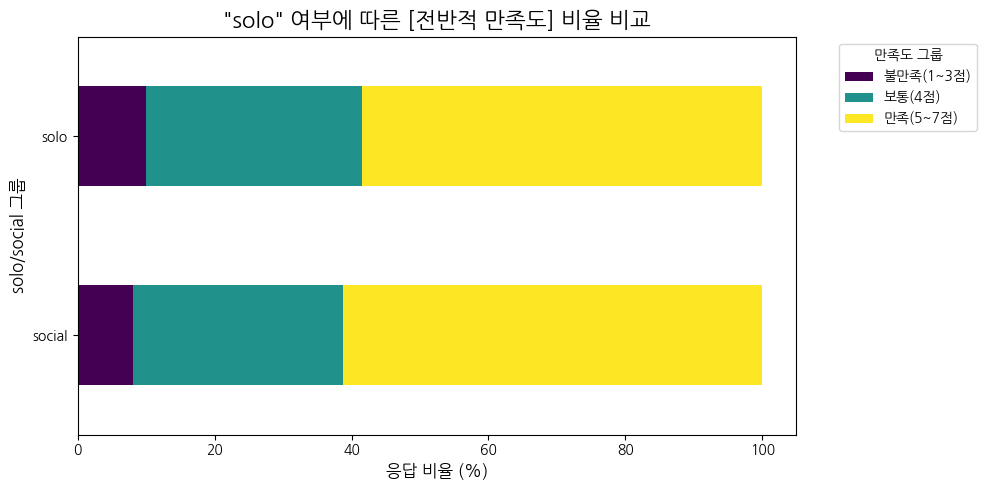


[카이제곱 검정 p-value]: 0.0015
[Mann-Whitney U] 결론 (p=0.0572): solo 여부가 "전반적 만족도"에 미치는 영향은 [유의미하지 않음]


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu
import numpy as np

# 1. '만족도' 범주화
bins = [0, 3, 4, 7]
labels = ['불만족(1~3점)', '보통(4점)', '만족(5~7점)']

# '만족도_그룹_전반적'이라는 새 파생 변수 생성
leisure['만족도_그룹_전반적'] = pd.cut(leisure['만족도_전반적'], bins=bins, labels=labels, right=True)

# 0/1을 'social/solo' 텍스트로 매핑
leisure['solo_status'] = leisure['solo_여부'].map({0: 'social', 1: 'solo'})

# 2. 교차표 생성 (카이제곱)
crosstab_table = pd.crosstab(leisure['solo_status'], leisure['만족도_그룹_전반적'])
crosstab_percent = pd.crosstab(leisure['solo_status'], leisure['만족도_그룹_전반적'], normalize='index') * 100

print('\n["전반적 만족도" 교차표 (비율 %)]')
print(crosstab_percent.round(2))

# 3. 그래프 (보고서용)
crosstab_percent.plot(kind='barh', stacked=True, figsize=(10, 5), colormap='viridis')

plt.title('"solo" 여부에 따른 [전반적 만족도] 비율 비교', fontsize=16)
plt.xlabel('응답 비율 (%)', fontsize=12)
plt.ylabel('solo/social 그룹', fontsize=12)
plt.legend(title='만족도 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. 통계 검정 (카이제곱 + Mann-Whitney U)
chi2, p_value_chi2, _, _ = chi2_contingency(crosstab_table)
print(f'\n[카이제곱 검정 p-value]: {p_value_chi2:.4f}')

group_solo_overall = leisure[leisure['solo_여부'] == 1]['만족도_전반적'].dropna()
group_social_overall = leisure[leisure['solo_여부'] == 0]['만족도_전반적'].dropna()
mw_test_overall = stats.mannwhitneyu(group_solo_overall, group_social_overall, alternative='two-sided')

alpha = 0.05
if mw_test_overall.pvalue < alpha:
  print(f'[Mann-Whitney U] 결론 (p={mw_test_overall.pvalue:.4f}): solo 여부가 "전반적 만족도"에 미치는 영향은 [유의미함]')
else:
  print(f'[Mann-Whitney U] 결론 (p={mw_test_overall.pvalue:.4f}): solo 여부가 "전반적 만족도"에 미치는 영향은 [유의미하지 않음]')

2. 만족도_참여1순위 (보조)


["참여1순위 만족도" 교차표 (비율 %)]
만족도_그룹_활동    불만족(1~3점)  보통(4점)  만족(5~7점)
solo_status                             
social            0.40   11.53     88.07
solo              0.46   10.63     88.91


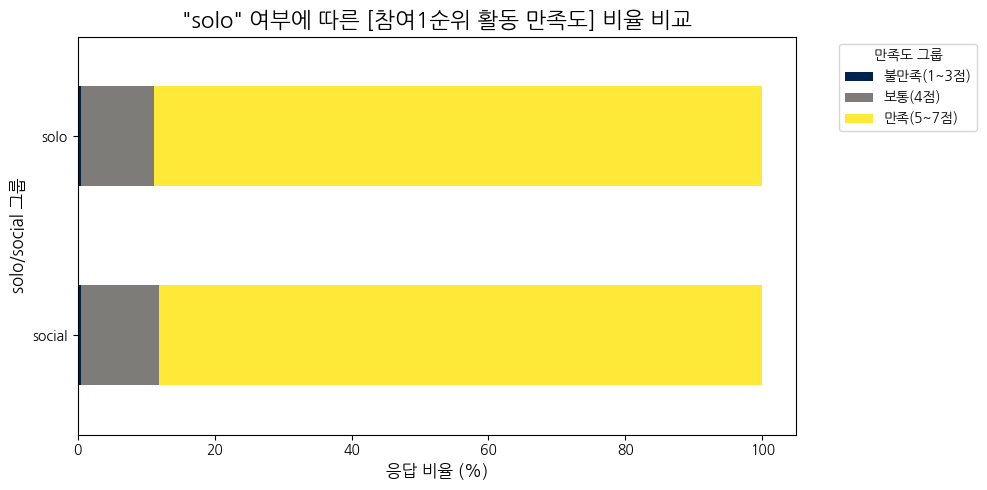


[카이제곱 검정 p-value]: 0.3344
[Mann-Whitney U] 결론 (p=0.0000): solo 여부가 "참여1순위 활동 만족도"에 미치는 영향은 [유의미함]


In [ ]:
# 1. '만족도' 범주화 (중복으로 주석 처리)
#bins = [0, 3, 4, 7]
#labels = ['불만족(1~3점)', '보통(4점)', '만족(5~7점)']

# '만족도_그룹_활동'이라는 새 파생 변수 생성
leisure['만족도_그룹_활동'] = pd.cut(leisure['만족도_참여1순위'], bins=bins, labels=labels, right=True)

# 0/1을 'social/solo' 텍스트로 매핑 (중복으로 주석 처리)
#leisure['solo_status'] = leisure['solo_여부'].map({0: 'social', 1: 'solo'})

# 2. 교차표 생성 (카이제곱)
crosstab_table_act = pd.crosstab(leisure['solo_status'], leisure['만족도_그룹_활동'])
crosstab_percent_act = pd.crosstab(leisure['solo_status'], leisure['만족도_그룹_활동'], normalize='index') * 100

print('\n["참여1순위 만족도" 교차표 (비율 %)]')
print(crosstab_percent_act.round(2))

# 3. 그래프 (보고서용)
crosstab_percent_act.plot(kind='barh', stacked=True, figsize=(10, 5), colormap='cividis')

plt.title('"solo" 여부에 따른 [참여1순위 활동 만족도] 비율 비교', fontsize=16)
plt.xlabel('응답 비율 (%)', fontsize=12)
plt.ylabel('solo/social 그룹', fontsize=12)
plt.legend(title='만족도 그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. 통계 검정 (카이제곱 + Mann-Whitney U)
chi2_act, p_value_chi2_act, _, _ = chi2_contingency(crosstab_table_act)
print(f'\n[카이제곱 검정 p-value]: {p_value_chi2_act:.4f}')

group_solo_act = leisure[leisure['solo_여부'] == 1]['만족도_참여1순위'].dropna()
group_social_act = leisure[leisure['solo_여부'] == 0]['만족도_참여1순위'].dropna()
mw_test_act = stats.mannwhitneyu(group_solo_act, group_social_act, alternative='two-sided')

alpha = 0.05
if mw_test_act.pvalue < alpha:
  print(f'[Mann-Whitney U] 결론 (p={mw_test_act.pvalue:.4f}): solo 여부가 "참여1순위 활동 만족도"에 미치는 영향은 [유의미함]')
else:
  print(f'[Mann-Whitney U] 결론 (p={mw_test_act.pvalue:.4f}): solo 여부가 "참여1순위 활동 만족도"에 미치는 영향은 [유의미하지 않음]')

3. 만족도 현상 시각화 (What: 현상 분석) <br>
: 전반적 만족도에는 차이가 없지만(p=0.057), 1순위 활동 만족도는 유의미하게 차이가 났다(p=0.0000246)는 현상을 **듀얼 Box Plot**으로 1차 증명

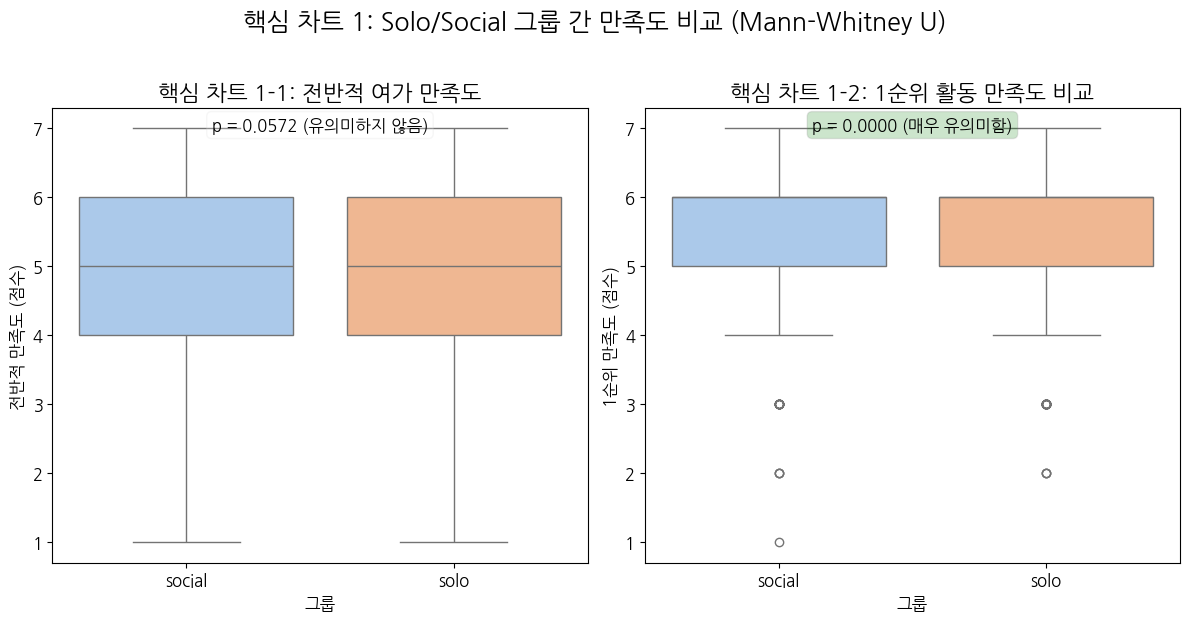

In [ ]:
# 차트 크기 설정
plt.figure(figsize=(12, 6))
plt.suptitle('핵심 차트 1: Solo/Social 그룹 간 만족도 비교 (Mann-Whitney U)', fontsize=18, y=1.03)

# 1. '만족도_전반적' 차트 생성 (왼 차트)
plt.subplot(1, 2, 1)
sns.boxplot(
    x='solo_status',
    y='만족도_전반적',
    data=leisure,
    palette = 'pastel',
    hue='solo_status',
    legend=False
)
plt.title('핵심 차트 1-1: 전반적 여가 만족도', fontsize=16)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('전반적 만족도 (점수)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# p-value 텍스트 추가
plt.text(0.5, 0.95, "p = 0.0572 (유의미하지 않음)",
         horizontalalignment = 'center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray', lw=1, alpha=0.2))

# 2. '만족도_참여1순위' 차트 생성 (오른쪽 차트)
plt.subplot(1, 2, 2)
sns.boxplot(
    x='solo_status',
    y='만족도_참여1순위',
    data=leisure,
    palette='pastel',
    hue='solo_status',
    legend=False
)
plt.title('핵심 차트 1-2: 1순위 활동 만족도 비교', fontsize=16)
plt.xlabel('그룹', fontsize=12)
plt.ylabel('1순위 만족도 (점수)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# p-value 텍스트 추가
plt.text(0.5, 0.95, "p = 0.0000 (매우 유의미함)",
         horizontalalignment = 'center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='green', ec='gray', lw=1, alpha=0.2))

# 3. 레이아웃 최적화 및 출력
plt.tight_layout()
plt.show()

-  violineplot 사용
: boxplot으로는 값 차이가 직관적으로 안 보임



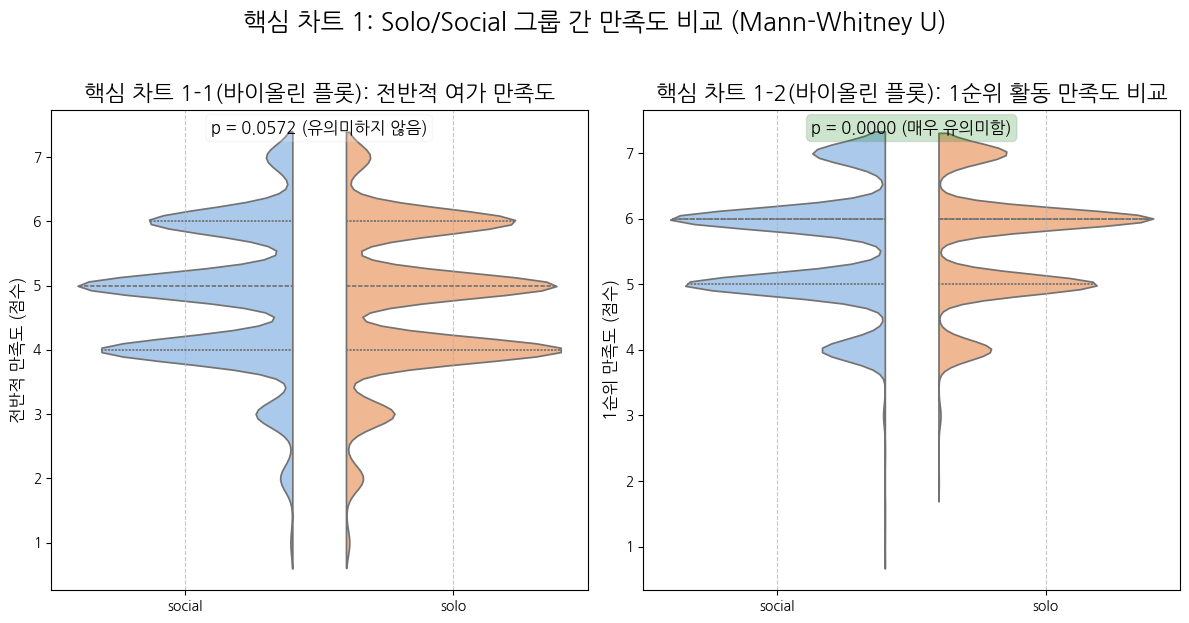

In [ ]:
# 차트 크기 설정
plt.figure(figsize=(12, 6))
plt.suptitle('핵심 차트 1: Solo/Social 그룹 간 만족도 비교 (Mann-Whitney U)', fontsize=18, y=1.03)

# 1. '만족도_전반적' 차트 생성 (왼족 차트)
plt.subplot(1, 2, 1)
ax1 = sns.violinplot(
    x='solo_status',
    y='만족도_전반적',
    data=leisure,
    palette = 'pastel',
    hue='solo_status',
    split=True, # 두 그룹을 겹쳐서 그림
    inner='quart'
)
plt.title('핵심 차트 1-1(바이올린 플롯): 전반적 여가 만족도', fontsize=16)
plt.xlabel(None)
plt.ylabel('전반적 만족도 (점수)', fontsize=12)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

# p-value 텍스트 추가
plt.text(0.5, 0.95, "p = 0.0572 (유의미하지 않음)",
         horizontalalignment = 'center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='lightgray', lw=1, alpha=0.2))

# 2. '만족도_참여1순위' 차트 생성 (오른쪽 차트)
plt.subplot(1, 2, 2)
ax2 = sns.violinplot(
    x='solo_status',
    y='만족도_참여1순위',
    data=leisure,
    palette='pastel',
    hue='solo_status',
    split=True,
    inner='quart'
)
plt.title('핵심 차트 1-2(바이올린 플롯): 1순위 활동 만족도 비교', fontsize=16)
plt.xlabel(None)
plt.ylabel('1순위 만족도 (점수)', fontsize=12)

ax2.grid(axis='x', linestyle='--', alpha=0.7)

# p-value 텍스트 추가
plt.text(0.5, 0.95, "p = 0.0000 (매우 유의미함)",
         horizontalalignment = 'center', transform=plt.gca().transAxes,
         fontsize=12, bbox=dict(boxstyle='round,pad=0.3', fc='green', ec='gray', lw=1, alpha=0.2))

# 3. 레이아웃 최적화 및 출력
plt.tight_layout()
plt.show()

##### 2. **원인 규명(Why)**
"그렇다면 만족도 차이를 만드는 **진짜 원인(Why)** 은 무엇인가?"

🚀 "Why" 분석을 위한 좋은 방법: **K-Means 클러스터링** <br>

목표: 'Solo/Social'이라는 낡은 구분을 버리고, '제약'이라는 변수들을 기준으로 사람들을 새롭게 묶습니다. <br>(C0: 고제약 그룹, C1: 저제약 그룹)

논리: 이렇게 묶고 보니, "C0 그룹은 Solo/Social 여부와 상관없이 모두 만족도가 낮았다"라는 결론을 도출하는 것이 목적

1. (Why-1) 모델링용 데이터 선택 및 스케일링

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. (Why-1) K-Means 모델링용 데이터 준비 ---
# (예: 'solo_여부', '싱글_여부' 같은 '결과' 변수는 제외)

model_cols = [
    # 인구통계 제약
    '나이',                  # (고령 제약)
    '소득_가구',              # (경제적 제약)
    '주당_평균_근무시간_kmeans', # (객관적 시간 제약)

    # 주관적 제약 (1~7점)
    '제약_시간', '제약_비용', '제약_질병장애', '제약_고립',
    '제약_시설접근', '제약_정보부족', '제약_경험부족', '제약_프로그램', '제약_기후여건',

    # 상태 제약
    '시간자유도_평일', '시간자유도_휴일', '이용 충분도',
    '인식_사회적관계', '인식_정신건강', '인식_신체건강상태',
    '장애여부',

    # 활동량
    '활동참여_총횟수'
]

# (컬럼명 확인)
model_cols_final = [col for col in model_cols if col in leisure.columns]
print(f"K-Means에 사용될 변수 개수: {len(model_cols_final)}개")

# --- 1-2. '마스터 leisure'에서 모델링용 데이터만 선택 ---
data_for_kmeans = leisure[model_cols_final]

# --- 1-3. 데이터 스케일링 (필수) ---
# K-Means는 '거리' 기반이라, 변수들의 단위를 통일해야 함
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_kmeans)

print("-> K-Means 입력용 데이터 스케일링 완료")

K-Means에 사용될 변수 개수: 20개
-> K-Means 입력용 데이터 스케일링 완료


2. (Why-2) 최적의 K 찾기 (Elbow Method)

'고제약' / '저제약' 2개 그룹(K=2)이 좋을지, 3~4개가 좋을지 확인

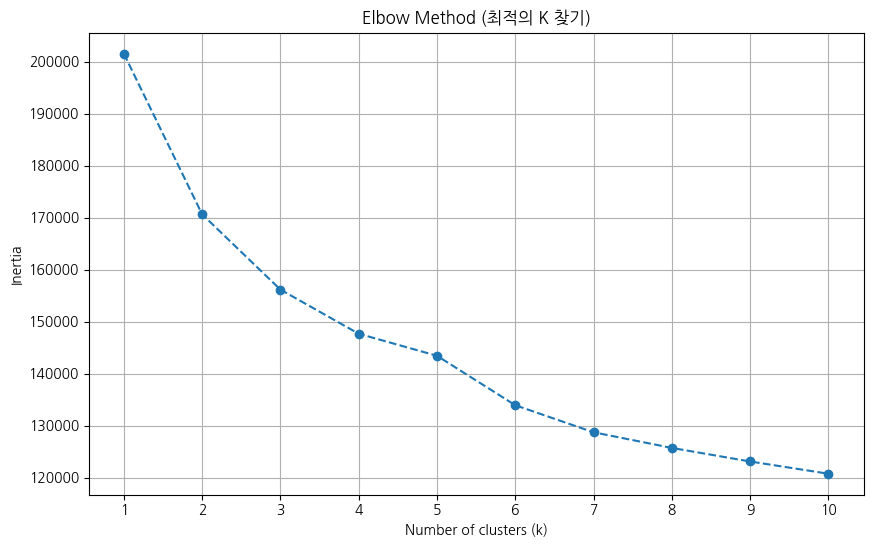

In [ ]:
# 1. k값을 1부터 10까지 테스트하여 Inertia(응집도, SSE) 측정
inertia_list = []
k_range = range(1, 11)

for k in k_range:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0, n_init='auto')
  kmeans.fit(scaled_data)
  inertia_list.append(kmeans.inertia_)

# 2. Elbow Method 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_list, marker='o', linestyle='--')
plt.title('Elbow Method (최적의 K 찾기)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

k=2: 실루엣 점수: 0.1381
k=3: 실루엣 점수: 0.1292
k=4: 실루엣 점수: 0.1031
k=5: 실루엣 점수: 0.0790
k=6: 실루엣 점수: 0.0909
k=7: 실루엣 점수: 0.0876
k=8: 실루엣 점수: 0.0893
k=9: 실루엣 점수: 0.0779
k=10: 실루엣 점수: 0.0751
k=11: 실루엣 점수: 0.0745
k=12: 실루엣 점수: 0.0730
k=13: 실루엣 점수: 0.0732
k=14: 실루엣 점수: 0.0730
k=15: 실루엣 점수: 0.0736
k=16: 실루엣 점수: 0.0754
k=17: 실루엣 점수: 0.0722
k=18: 실루엣 점수: 0.0693
k=19: 실루엣 점수: 0.0694
k=20: 실루엣 점수: 0.0690


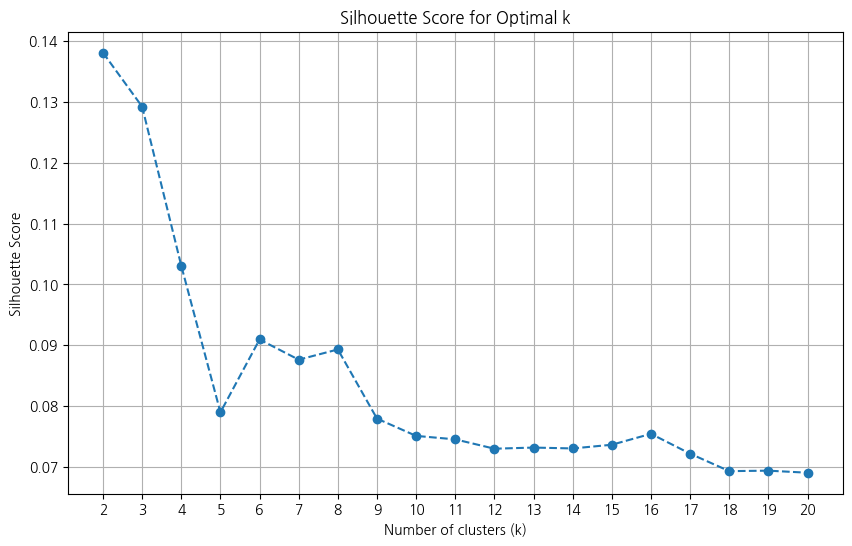

In [ ]:
# 실루엣 점수 구하기
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range_silhouette = range(2, 21)

for k in k_range_silhouette:
  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0, n_init='auto')
  labels = kmeans.fit_predict(scaled_data)

  # 실루엣 점수 계산
  # silhouette_score(데이터, 레이블)
  score = silhouette_score(scaled_data, labels)
  silhouette_scores.append(score)

  print(f'k={k}: 실루엣 점수: {score:.4f}')

# 실루엣 점수 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

3. (Why-3) K-Means 모델 실행 및 결과 병합

실루엣 계수를 통해 k=2 설정

In [ ]:
K_OPTIMAL = 2

kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
kmeans.fit(scaled_data)

# [★가장 중요★]
# K-Means 결과를 '마스터 leisure'에 'cluster'라는 새 컬럼으로 붙입니다.
leisure['cluster'] = kmeans.labels_

print(f"-> K={K_OPTIMAL} 클러스터링 완료. 'leisure'에 'cluster' 컬럼 추가됨.")
print(leisure['cluster'].value_counts())

-> K=2 클러스터링 완료. 'leisure'에 'cluster' 컬럼 추가됨.
cluster
1    5260
0    4815
Name: count, dtype: int64


4. 차트 1: C0 vs C1 '전반적 만족도' 비교

진짜 원인을 규명하는 단계

/tmp/ipython-input-966511610.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


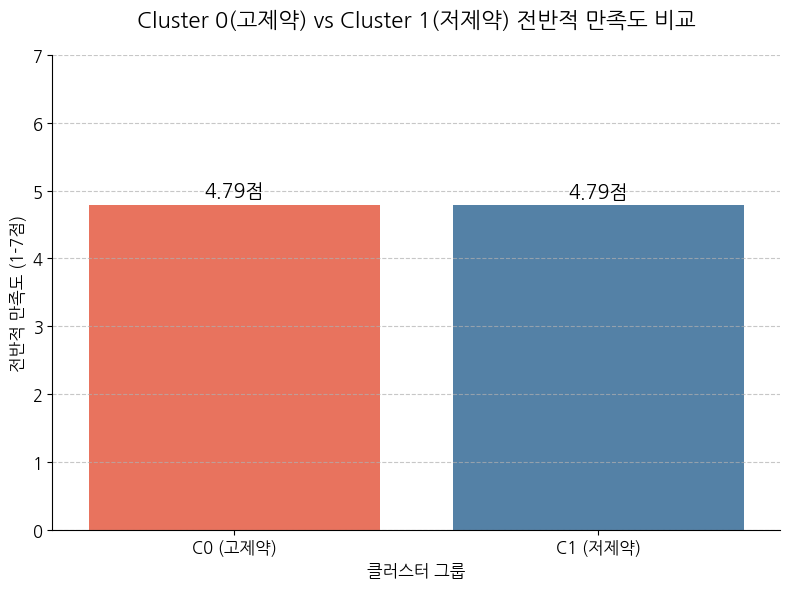

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 원본 데이터 계산 (기존 코드 활용)
# (C0=0, C1=1 이라고 가정)
satisfaction_means = leisure.groupby('cluster')['만족도_전반적'].mean().reset_index()
satisfaction_means['cluster_label'] = satisfaction_means['cluster'].map({0: 'C0 (고제약)', 1: 'C1 (저제약)'})

# 2. 시각화
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x='cluster_label',
    y='만족도_전반적',
    data=satisfaction_means,
    palette=['#FF6347', '#4682B4'] # C0는 붉은색, C1은 푸른색 계열
)

# 3. [★핵심★] Y축 스케일을 0~7점(전체 척도)으로 고정
plt.ylim(0, 7)

# 4. 값(숫자) 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}점',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14,
                fontweight='bold')

# 5. 차트 제목 및 레이블
plt.title("Cluster 0(고제약) vs Cluster 1(저제약) 전반적 만족도 비교", fontsize=16, pad=20)
plt.xlabel("클러스터 그룹", fontsize=12)
plt.ylabel("전반적 만족도 (1-7점)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine() # 테두리 정리
plt.tight_layout()
#plt.savefig('cluster_satisfaction_barplot.png') # 파일로 저장
plt.show()

/tmp/ipython-input-1271688641.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


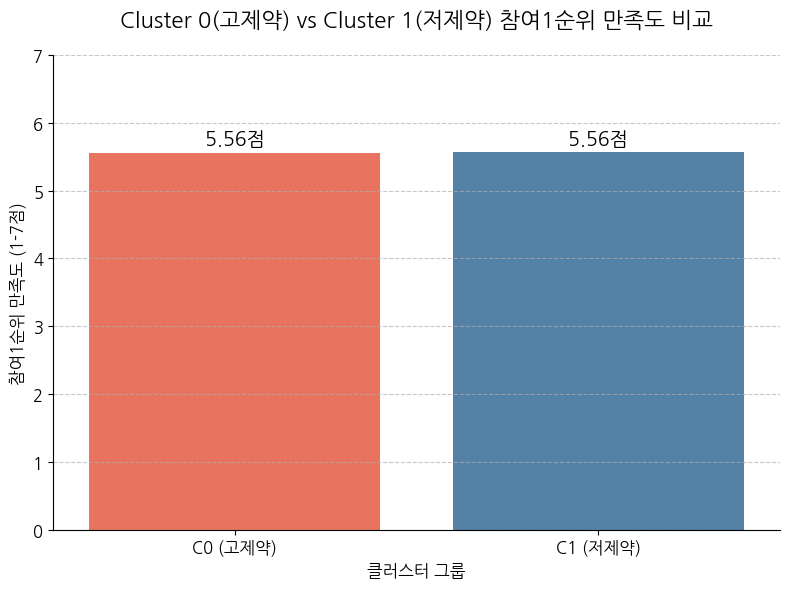

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 원본 데이터 계산 (기존 코드 활용)
# (C0=0, C1=1 이라고 가정)
satisfaction_means = leisure.groupby('cluster')['만족도_참여1순위'].mean().reset_index()
satisfaction_means['cluster_label'] = satisfaction_means['cluster'].map({0: 'C0 (고제약)', 1: 'C1 (저제약)'})

# 2. 시각화
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x='cluster_label',
    y='만족도_참여1순위',
    data=satisfaction_means,
    palette=['#FF6347', '#4682B4'] # C0는 붉은색, C1은 푸른색 계열
)

# 3. [★핵심★] Y축 스케일을 0~7점(전체 척도)으로 고정
plt.ylim(0, 7)

# 4. 값(숫자) 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}점',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=14,
                fontweight='bold')

# 5. 차트 제목 및 레이블
plt.title("Cluster 0(고제약) vs Cluster 1(저제약) 참여1순위 만족도 비교", fontsize=16, pad=20)
plt.xlabel("클러스터 그룹", fontsize=12)
plt.ylabel("참여1순위 만족도 (1-7점)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine() # 테두리 정리
plt.tight_layout()
#plt.savefig('cluster_satisfaction_barplot.png') # 파일로 저장
plt.show()

5. 차트 2: C0 (고제약 집단) 내 Solo/Social 비중
+) C1 내 solo/social 비중도 확인

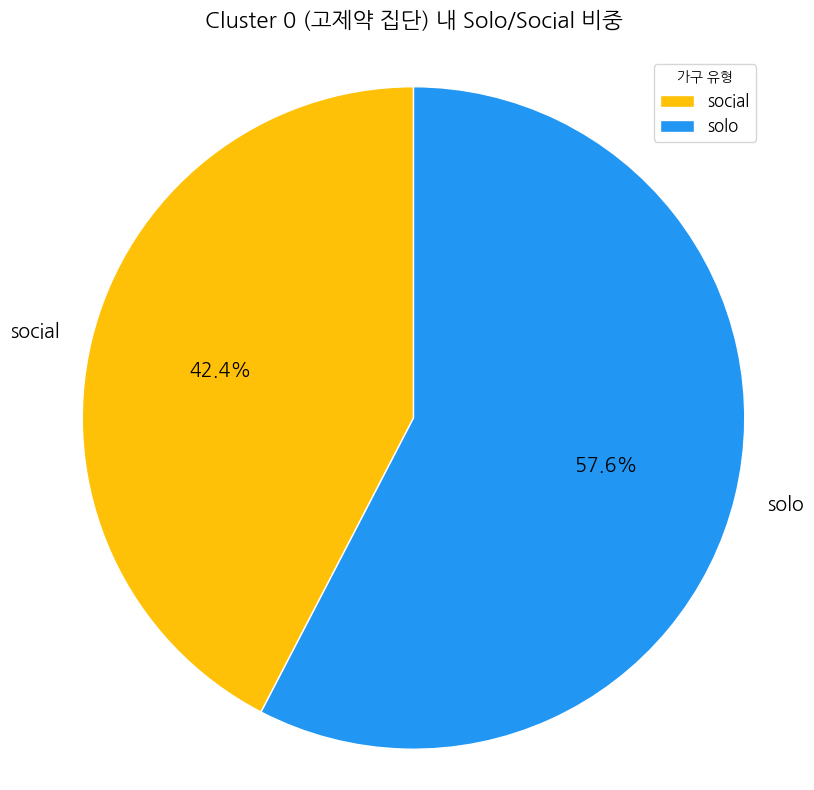

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 원본 데이터 계산 (기존 코드 활용)
# (C0=0, C1=1 / solo_status는 0/1이 아닌 'solo', 'social' 텍스트라고 가정)
# (만약 'solo_status'가 없다면 `leisure['solo_status'] = leisure['solo_여부'].map({0: 'Social', 1: 'Solo'})`를 먼저 실행)
# leisure['solo_status'] = leisure['solo_여부'].map({0: 'Social', 1: 'Solo'}
crosstab_data = pd.crosstab(leisure['cluster'], leisure['solo_status'], normalize='index')

# 2. C0 (고제약) 데이터만 추출 (C0=0 이라고 가정)
c0_proportions = crosstab_data.loc[0]
labels = c0_proportions.index
sizes = c0_proportions.values

# 3. 파이 차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', # 소수점 한 자리 % 표시
    startangle=90,
    colors=['#FFC107', '#2196F3'], # Solo/Social 색상 지정
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1} # 조각 경계선
)

# 4. 차트 제목
plt.title("Cluster 0 (고제약 집단) 내 Solo/Social 비중", fontsize=16, pad=20)
plt.axis('equal') # 파이 차트를 원형으로
plt.legend(title="가구 유형", loc="upper right", fontsize=12)
plt.tight_layout()
#plt.savefig('cluster_solo_piechart.png')
plt.show()

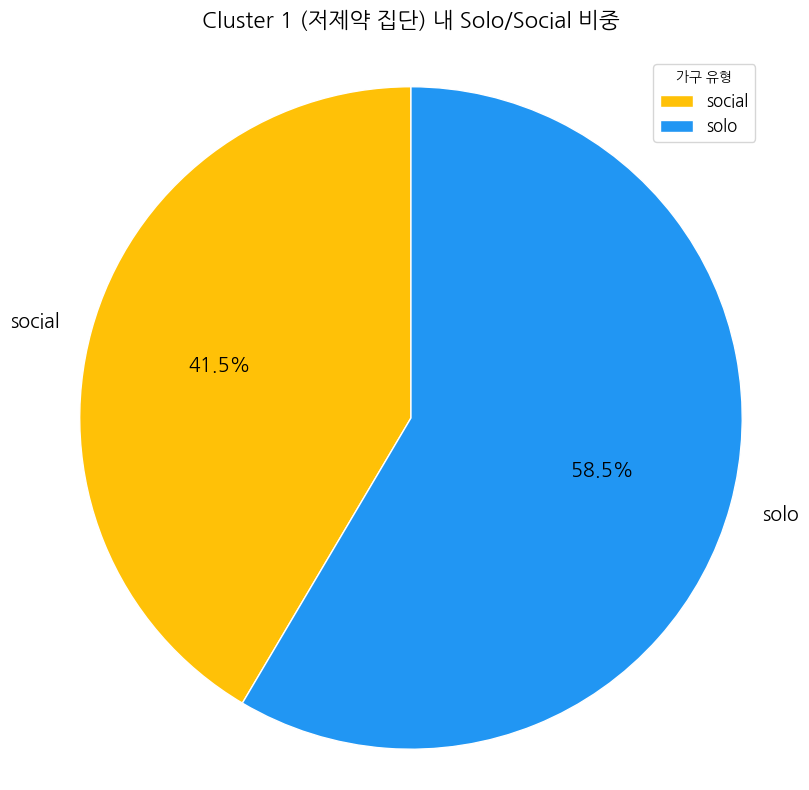

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 원본 데이터 계산 (기존 코드 활용)
# (C0=0, C1=1 / solo_status는 0/1이 아닌 'solo', 'social' 텍스트라고 가정)
# (만약 'solo_status'가 없다면 `leisure['solo_status'] = leisure['solo_여부'].map({0: 'Social', 1: 'Solo'})`를 먼저 실행)
# leisure['solo_status'] = leisure['solo_여부'].map({0: 'Social', 1: 'Solo'}
crosstab_data = pd.crosstab(leisure['cluster'], leisure['solo_status'], normalize='index')

# 2. C1 (저제약) 데이터만 추출 (C1=1 이라고 가정)
c1_proportions = crosstab_data.loc[1]
labels = c1_proportions.index
sizes = c1_proportions.values

# 3. 파이 차트 시각화
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%', # 소수점 한 자리 % 표시
    startangle=90,
    colors=['#FFC107', '#2196F3'], # Solo/Social 색상 지정
    textprops={'fontsize': 14, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1} # 조각 경계선
)

# 4. 차트 제목
plt.title("Cluster 1 (저제약 집단) 내 Solo/Social 비중", fontsize=16, pad=20)
plt.axis('equal') # 파이 차트를 원형으로
plt.legend(title="가구 유형", loc="upper right", fontsize=12)
plt.tight_layout()
#plt.savefig('cluster_solo_piechart.png')
plt.show()

#### 핵심 동인 분석 (OLS 다중 회귀 분석): How much?

- 목표: '만족도_참여1순위(Y)'에 '여러 변수들(X)'이 얼마나 영향을 미치는 정량적으로 측정
- X (독립 변수)를 '가설'과 '제약'으로 재구성
1. **"가설 1" (solo_여부)** 을 넣음

2. **"가설 2" (제약 변수들)** 를 모두 넣음.

3. **"통제 변수" (나이, 소득 등)** 를 넣음.

4. "오염 변수"('즐겨하는_여가활동', 다른 '만족도' 컬럼)는 모두 제거

OLS는 "가설 1"과 "가설 2"를 직접 경쟁시켜 **"누가 진짜 원인인지"** 밝혀내는 것이 목표

1. X_process 생성 및 VIF 테스트
- 목적: '모델링용'(leisure_model') 데이터에서 `X_processed`(최종 X)와 `Y`(최종 Y)를 생성
- 희소 값 처리(Lumping) 적용

In [ ]:
# 변수 분리  데이터 전처리
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Y(종속 변수) 정의
Y_final = leisure['만족도_참여1순위']

# 2. X(독립 변수) 정의
numeric_cols = [
    # [가설 1]
    'solo_여부',

    # [가설 2] 제약 변수들
    '제약_시간', '제약_비용', '제약_질병장애', '제약_고립',
    '제약_시설접근', '제약_정보부족', '제약_경험부족', '제약_프로그램', '제약_기후여건',

    # [통제] 인구통계 및 상태
    '나이',
    '소득_가구',
    '주당_평균_근무시간_kmeans',
    '시간자유도_평일',
    '시간자유도_휴일',
    '이용 충분도',
    '인식_사회적관계', '인식_정신건강', '인식_신체건강상태',
    '활동참여_총횟수'
]
categorical_cols = [
    '장애여부',
    '성별',
    '혼인상태', # ('싱글_여부'와 중복될 수 있으니 둘 중 하나만 선택)
    '유연근무제 시행 여부',
    '최종학력'
]

# (leisure에 실제 존재하는 컬럼만 필터링)
numeric_cols_final = [col for col in numeric_cols if col in leisure.columns]
categorical_cols_final = [col for col in categorical_cols if col in leisure.columns]

# 3-1. 스케일링 (숫자형 X 변수)
scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(leisure[numeric_cols_final]),
                         columns = numeric_cols_final,
                         index = leisure.index)

# 3-2. 더미 변수화 (범주형 X 변수)
X_categorical = pd.get_dummies(leisure[categorical_cols_final], drop_first=True, dtype=int)

# 4. X 변수 최종 통합
# 해당 변수가 VIF, OLS, K-Means, CV에서 공통으로 사용할 'X_final'
X_processed = pd.concat([X_numeric, X_categorical], axis=1)
print(f'X_processed (최종 X) 생성 완료 (Shape: {X_processed.shape}')

# 5. VIF 테스트 실행 (X_processed) 사용
# VIF 계산을 위해 상수항(절편) 추가
X_for_vif_const = sm.add_constant(X_processed)

vif = pd.DataFrame()
vif['Variable'] = X_for_vif_const.columns
vif['VIF'] = [variance_inflation_factor(X_for_vif_const.values, i) for i in range(X_for_vif_const.shape[1])]

# 'const' (상수항) 행은 VIF가 매우 높게 나오기 때문에 제외하고 확인
vif_results = vif[vif['Variable'] != 'const'].sort_values(by='VIF', ascending=False)

print('--- VIF 테스트 결과 (VIF > 5인 변수들) ---')
# (VIF가 5 또는 10을 초과하는 상위 20개만 출력)
print(vif_results[vif_results['VIF'] > 5].head(20).to_markdown(index=False, floatfmt='.2f'))

print("\n--- [VIF 진단] 의미가 겹칠 수 있는 '제약' 그룹 확인 ---")

# 1. '시간' 제약 그룹 (가장 겹칠 확률이 높음)
# "시간이 없다"는 주관적 응답 vs. "실제 근무 시간"
print("\n--- [그룹 1] 시간 제약 VIF ---")
time_vars = ['제약_시간', '주당_평균_근무시간_kmeans', '시간자유도_평일', '시간자유도_휴일']
print(vif_results[vif_results['Variable'].isin(time_vars)])

# 2. '건강' 제약 그룹
# "질병이 제약"이라는 응답 vs. "신체 건강 인식" vs. "실제 장애 여부"
print("\n--- [그룹 2] 건강/신체 제약 VIF ---")
health_vars = ['제약_질병장애', '인식_신체건강상태', '장애여부_True'] # '장애여부'가 더미화된 이름
print(vif_results[vif_results['Variable'].isin(health_vars)])

# 3. '사회/고립' 제약 그룹
# "동반자가 없어 제약"이라는 응답 vs. "주관적 고립감" vs. "혼인 상태"
print("\n--- [그룹 3] 사회/고립 제약 VIF ---")
social_vars = ['제약_고립', '인식_사회적관계', '혼인상태_미혼', '혼인상태_사별', '혼인상태_이혼'] # '혼인상태'가 더미화된 이름
print(vif_results[vif_results['Variable'].isin(social_vars)])

# 4. '경제' 제약 그룹
# "비용이 제약"이라는 응답 vs. "실제 소득"
print("\n--- [그룹 4] 경제 제약 VIF ---")
eco_vars = ['제약_비용', '소득_가구']
print(vif_results[vif_results['Variable'].isin(eco_vars)])

X_processed (최종 X) 생성 완료 (Shape: (10075, 33)
--- VIF 테스트 결과 (VIF > 5인 변수들) ---
| Variable   | VIF   |
|------------|-------|

--- [VIF 진단] 의미가 겹칠 수 있는 '제약' 그룹 확인 ---

--- [그룹 1] 시간 제약 VIF ---
             Variable       VIF
14           시간자유도_평일  2.000021
15           시간자유도_휴일  1.997202
2               제약_시간  1.703918
13  주당_평균_근무시간_kmeans  1.335358

--- [그룹 2] 건강/신체 제약 VIF ---
     Variable       VIF
19  인식_신체건강상태  2.004809
4     제약_질병장애  1.892133

--- [그룹 3] 사회/고립 제약 VIF ---
    Variable       VIF
5      제약_고립  2.645139
25   혼인상태_사별  2.342153
26   혼인상태_이혼  1.378404
17  인식_사회적관계  1.313715

--- [그룹 4] 경제 제약 VIF ---
   Variable       VIF
12    소득_가구  1.589099
3     제약_비용  1.520930


2. OLS 회귀 분석: 모델 훈련
- `X_processed`와 `Y_final`을 사용하여 OLS 모델을 실행하고 `ols_model_results`를 생성

In [ ]:
import statsmodels.api as sm

# 모델 훈련 및 핵심 동인 확정
X_processed_const = sm.add_constant(X_processed)

# OLS 모델 훈련
ols_model_results = sm.OLS(Y_final, X_processed_const).fit()

# 결과 요약
print(ols_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              만족도_참여1순위   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     41.01
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          4.56e-246
Time:                        20:11:35   Log-Likelihood:                -12322.
No. Observations:               10075   AIC:                         2.471e+04
Df Residuals:                   10041   BIC:                         2.496e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.5025      0.02

In [ ]:
import pandas as pd

# (가정) 8단계 OLS 모델이 'ols_model_results' 변수에 저장되어 있음
# (가정) 'significant_vars' (p-value < 0.05)가 이미 생성됨

# 1. OLS 결과 객체에서 '계수(coef)'와 'p-value'를 데이터프레임으로 추출
ols_results = pd.DataFrame({
    'coef': ols_model_results.params,
    'pvalue': ols_model_results.pvalues
})

# 2. 유의미한 변수만 선별
significant_vars = ols_results[
    (ols_results['pvalue'] < 0.05) &
     (ols_results.index != 'const')
]


# --- coef 크기가 '가장 낮은' (가장 부정적인) 목록 ---

# 3. [부정적] 핵심 변수 (significant_vars에서 coef가 0보다 작은 것만 선택)
negative_core = significant_vars[significant_vars['coef'] < 0].sort_values(
    by='coef',
    ascending=True  # [★중요★] 'True' (오름차순)로 설정
)

# 4. 결과 출력
print(f"--- '활동 만족도'를 깎아 먹는 진짜 원인(Why) ---")
display(negative_core.head(10))

# 5. (필요시) 이 변수들의 '이름'만 리스트로 저장
negative_vars_list = negative_core.index.tolist()
print(negative_vars_list)

--- '활동 만족도'를 깎아 먹는 진짜 원인(Why) ---


,coef,pvalue
제약_질병장애,-0.080866,8.286921e-13
인식_사회적관계,-0.078611,7.109829e-17
주당_평균_근무시간_kmeans,-0.052516,3.112845e-08
제약_고립,-0.027639,3.834440e-02


['제약_질병장애', '인식_사회적관계', '주당_평균_근무시간_kmeans', '제약_고립']


In [ ]:
# =========================================================================
# 📌 OLS 핵심 변수 추출 (최종 보고서 변수 이름 통일)
# =========================================================================

# 1. 부정적 제약 변수만 필터링 (Solo/Demographics 제외)
# (negative_core는 OLS 분석 결과에서 부정적인 영향을 미치는 변수만 모아 정렬한 DataFrame입니다.)
negative_barriers_only = negative_core[negative_core.index.str.startswith('제약_')]

# 2. OLS 결과에서 1순위 장벽 정보 추출 (변수 이름: top_name, top_coef)
# .index[0]은 변수 이름을, .iloc[0]['coef']는 계수 값을 가져옵니다.
top_name = negative_barriers_only.index[0]
top_coef = negative_barriers_only.iloc[0]['coef']

# 3. OLS 결과에서 2순위 장벽 정보 추출 (변수 이름: second_name, second_coef)
second_name = negative_barriers_only.index[1]
second_coef = negative_barriers_only.iloc[1]['coef']

print("✅ OLS 핵심 변수 추출 완료 (top_name, top_coef 변수 정의 완료)")

# =========================================================================

✅ OLS 핵심 변수 추출 완료 (top_name, top_coef 변수 정의 완료)


3. OLS 회귀 진단 플롯
- 해석:

p-value와 coef 값의 '통계적 신뢰도'를 맹신해선 안 된다

하지만
- "이 모델은 **'정확한 예측'**을 위한 모델이 아니라, **'핵심 원인(Driver)'을 찾기 위한** 모델이다."
- `R-squared: 0.119`가 비록 낮아도, "만족도"라는 복잡한 변수를 11.9%나 설명하는 **유의미한 모델**이다.
- `coef` (계수) 값은, 통계적 가정이 깨졌더라도, 변수들 간의 **'영향력의 방향성'(+ 또는 -)**과 **'상대적인 중요도'**를 파악하는 데 **가장 훌륭한 근거**이다.
    - (예: '질병장애'(-0.08)가 '고립'(-0.02)보다 **3배 더 강력한 부정적 요인**임을 알 수 있습니다.)
- `P>|t|` (p-value)가 `0.000`처럼 압도적으로 낮은 변수들은, "가정이 깨졌음에도 불구하고 **매우 강력한 관계**를 보여준다"는 뜻이다.

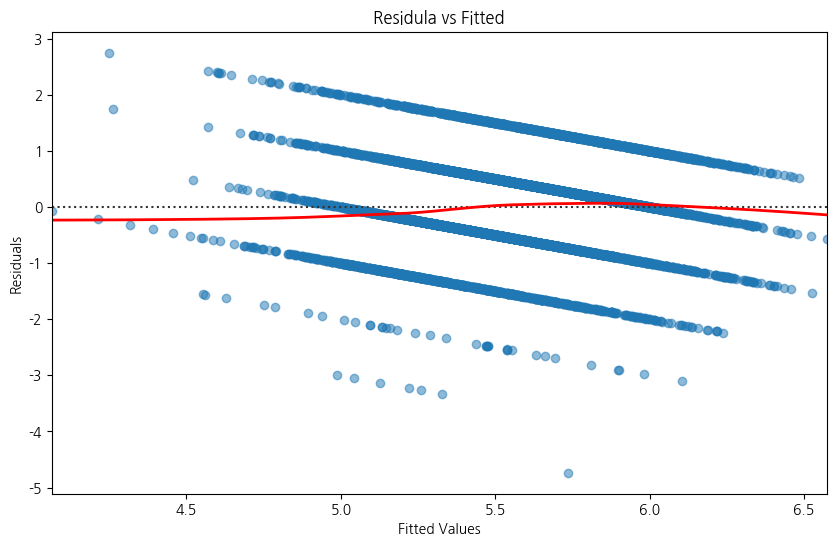

<Figure size 1000x500 with 0 Axes>

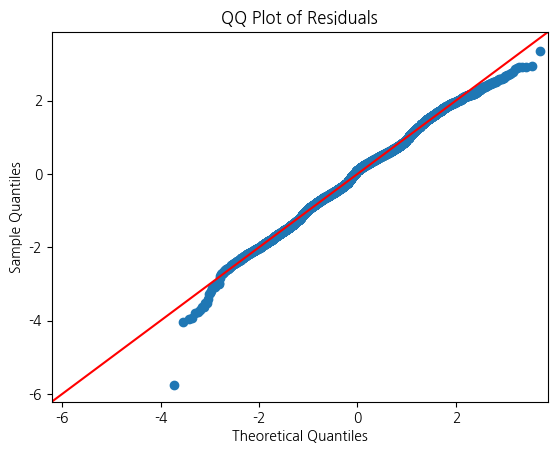

In [ ]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 잔차(Residuals) 추출
residuals = ols_model_results.resid

# 2. 예측값(Fitted values) 추출
fitted_values = ols_model_results.fittedvalues

# --- 플롯 1: 잔차의 등분산성 (Residual vs Fitted) ---
# 패턴 없이 0을 기준으로 무작위로 퍼져있어야 좋음
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_values, y=residuals, lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 2})
plt.title('Residula vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# --- 플롯 2: 잔차의 정규성 (QQ Plot) ---
# 점들이 빨간색 대각선(이론적 정규분포) 위에 거의 일치해야 좋음)
plt.figure(figsize=(10, 5))
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()

4. OLS 회귀분석 모델의 신뢰도를 검증하기 위한 교차검증
- 목적: 1,2단계의 결과물을 사용하여 모델의 신뢰도를 '검증'함

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# 독립변수
all_vars = ols_model_results.model.exog_names
# 상수항 제거
feature_columns = [var for var in all_vars if var != 'const']
print(f'추출된 변수 개수: {len(feature_columns)}')

# 교차 검증을 위한 X, y 준비
X_cv = X_processed[feature_columns]
Y_cv = Y_final


# 교차검증 설정
# 1. 모델 정의
model_cv = LinearRegression()

# 2. 교차검증 방법 정의: KFold
# 데이터를 5조각(n_splits=5)으로 나누고, 섞어서(shuffle=True) 실행
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# 3. 평가지표 설정: R-squared
scoring_metric = 'r2'

# 4. 교차검증 실행
scores = cross_val_score(model_cv, X_cv, Y_cv, scoring=scoring_metric, cv=kfold)

# 5. 결과 출력
print(f'\n--- 5-Fold Cross-Validation (R-Squared) ---')
print(f"OLS R-squared (학습 데이터): 0.119") # 님의 OLS 요약표 결과
print(f'교차검증 R2 평균 점수 (새 데이터): {np.mean(scores):.4f} ± {np.std(scores):.4f}')
print(f'개별 점수: {np.round(scores, 4)}')

추출된 변수 개수: 33

--- 5-Fold Cross-Validation (R-Squared) ---
OLS R-squared (학습 데이터): 0.119
교차검증 R2 평균 점수 (새 데이터): 0.1108 ± 0.0141
개별 점수: [0.1182 0.1215 0.0979 0.0902 0.1262]


5. K-Means 진단 (PCA 시각화)
- 121+개 변수를 2~3개 '주성분'으로 압축하여, K-Means 결과를 2D로 시각화

- 목적: K-Means가 나눈 C0/C1 그룹이 실제로 데이터 공간에서 잘 분리되었는지 시각적으로 확인. (보고서 도입부)

PCA 2개 주성분의 설명력: 0.37


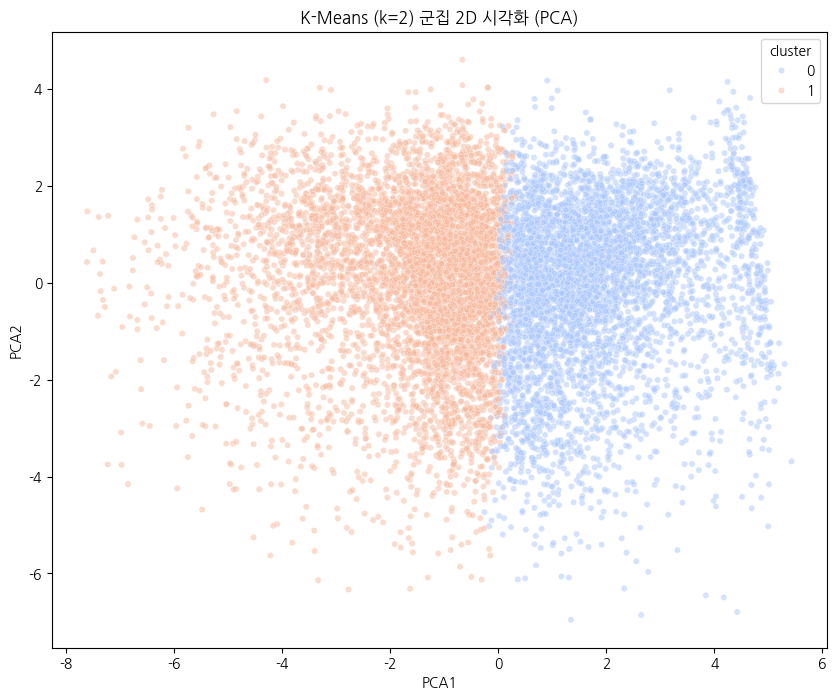

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. PCA로 2개 주성분으로 압축
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_processed)
print(f'PCA 2개 주성분의 설명력: {pca.explained_variance_ratio_.sum():.2f}')

# 2. PCA 결과(X_pca)에 'cluster' 꼬리표(k=2) 추가
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = kmeans.labels_

# 3. 2D 스캐터 플롯 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster',
                palette='coolwarm', alpha=0.5, s=20)
plt.title('K-Means (k=2) 군집 2D 시각화 (PCA)')
plt.show()

#### 🚀 최종 분석 정리 및 보고서 EXHIBITS 생성

Radar Chart
- 프로파일링의 `profile_comparison` 표(평균 대비 차이)를 '거미줄 차트'로 그려, Cluster 0과 Cluster 1의 프로파일을 한 눈에 비교

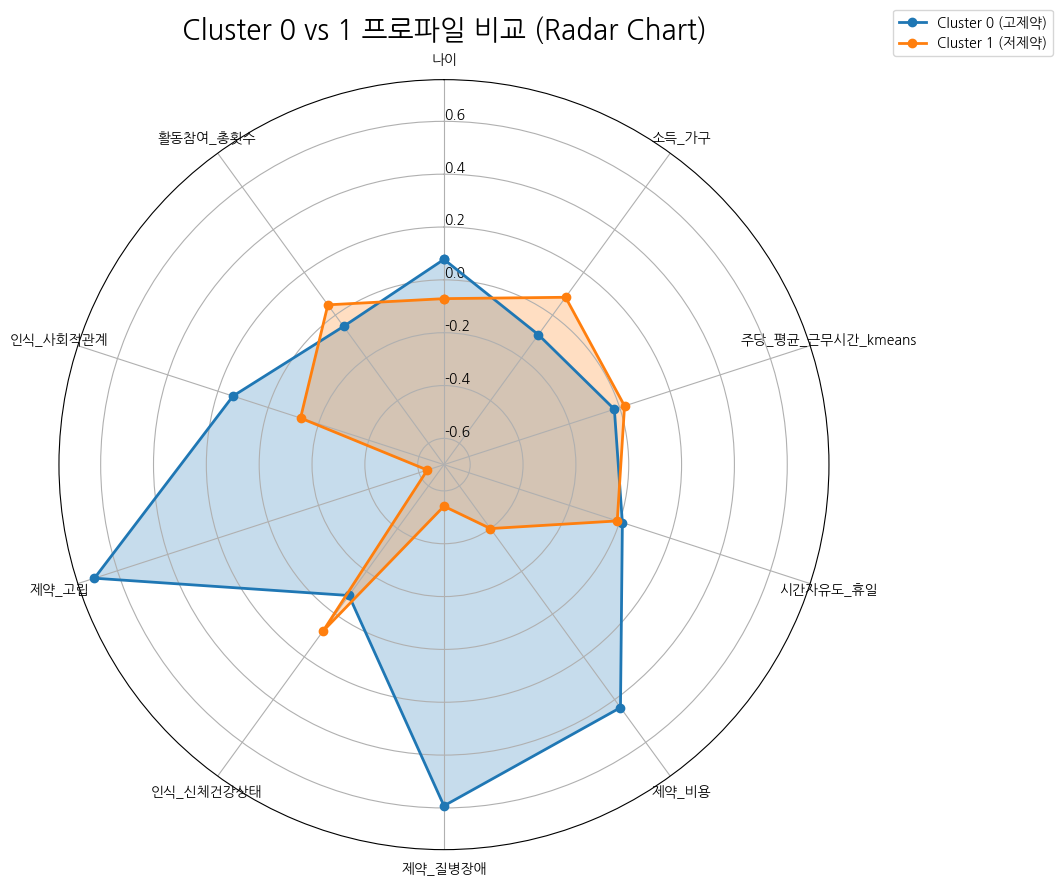

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 'X_processed'에 'cluster' 꼬리표 임시 병합
X_scaled_with_cluster = X_processed.copy()
X_scaled_with_cluster['cluster'] = leisure['cluster'].values

# '표준화된' 평균 계산
standardized_profile = X_scaled_with_cluster.groupby('cluster').mean()

# 1. 비교할 Top 10개 핵심 변수 선택
radar_vars = [
    '나이',
    '소득_가구',
    '주당_평균_근무시간_kmeans',
    '시간자유도_휴일',
    '제약_비용',
    '제약_질병장애',
    '인식_신체건강상태',
    '제약_고립',
    '인식_사회적관계',
    '활동참여_총횟수'
]

# 2. 데이터 준비 (Cluster 0, 1의 점수)
data_radar_std = standardized_profile[radar_vars].T
labels = data_radar_std.index
stats_c0 = data_radar_std[0].values # Cluster 0 점수
stats_c1 = data_radar_std[1].values # Cluster 1 점수

# 3. 각도 계산
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# 차트를 닫기 위해 시작점을 끝에 추가
stats_c0 = np.concatenate((stats_c0, [stats_c0[0]]))
stats_c1 = np.concatenate((stats_c1, [stats_c1[0]]))
angles = np.concatenate((angles, [angles[0]]))

# 4. Radar Chart 그리기
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Cluster 0 (고제약)
ax.plot(angles, stats_c0, 'o-', linewidth=2, label='Cluster 0 (고제약)')
ax.fill(angles, stats_c0, alpha=0.25)
# Cluster 1 (저제약)
ax.plot(angles, stats_c1, 'o-', linewidth=2, label='Cluster 1 (저제약)')
ax.fill(angles, stats_c1, alpha=0.25)

ax.set_rlabel_position(0)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Cluster 0 vs 1 프로파일 비교 (Radar Chart)\n', size=20)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

1. OLS 결과 해석: 최종 핵심 동인 도출 (Track 1 근거) <br>
이 코드는 만족도를 낮추는 유의미한 변수들을 coef 크기 순으로 정렬하여 정책의 우선순위를 제시

In [ ]:
import pandas as pd

# 1. OLS 결과 객체에서 '계수(coef)'와 'p-value'를 데이터프레임으로 추출
ols_results = pd.DataFrame({
    'coef': ols_model_results.params,
    'pvalue': ols_model_results.pvalues
})

# 2. 유의미한 변수만 선별 (p < 0.05)
significant_vars = ols_results[
    (ols_results['pvalue'] < 0.05) &
    (ols_results.index != 'const')
]

# 3. [부정적] 핵심 변수 (만족도를 낮추는 진짜 원인)
negative_core = significant_vars[significant_vars['coef'] < 0].sort_values(
    by='coef',
    ascending=True # 오름차순 (가장 부정적 영향이 큰 순서)
)

print(f"--- 만족도를 <<낮추는>> 핵심 변수 (coef가 가장 낮은 순) ---")
display(negative_core.head(10))

# 4. (정책 제안의 근거가 될) 핵심 변수 리스트 저장
negative_vars_list = negative_core.index.tolist()
print(f"\n▶ 정책 제안 근거 변수 리스트: {negative_vars_list[:4]}")

--- 만족도를 <<낮추는>> 핵심 변수 (coef가 가장 낮은 순) ---


,coef,pvalue
제약_질병장애,-0.080866,8.286921e-13
인식_사회적관계,-0.078611,7.109829e-17
주당_평균_근무시간_kmeans,-0.052516,3.112845e-08
제약_고립,-0.027639,3.834440e-02



▶ 정책 제안 근거 변수 리스트: ['제약_질병장애', '인식_사회적관계', '주당_평균_근무시간_kmeans', '제약_고립']


<Figure size 1000x700 with 0 Axes>

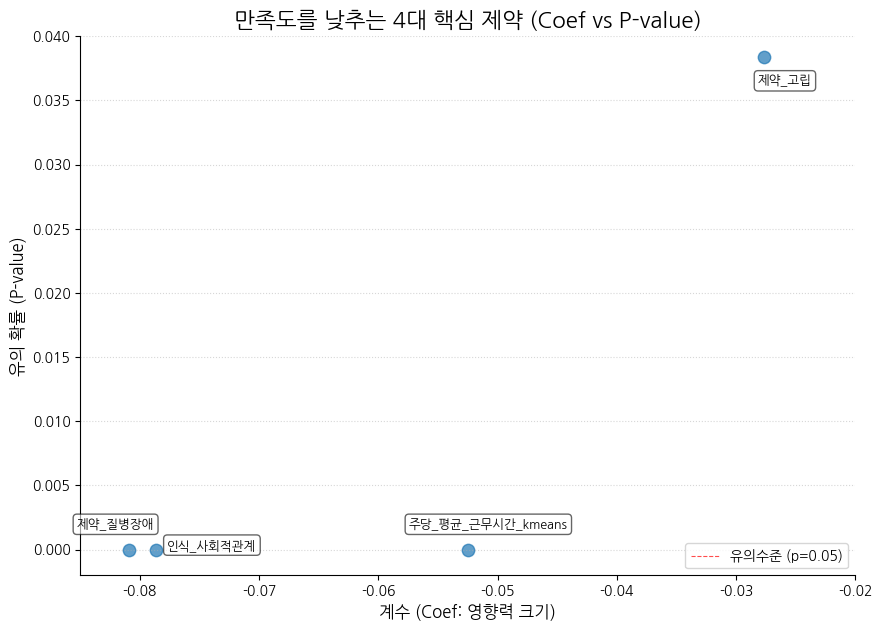

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np # np.nan을 처리하기 위해 필요

# (주의: negative_core DataFrame이 이미 정의되어 있어야 합니다.)

plt.figure(figsize=(10, 7))

# 1.플롯 객체를 ax에 명시적으로 할당
# (negative_core는 님의 OLS 결과에서 가져온 DataFrame으로 가정하고 진행합니다.)
ax = negative_core.plot(kind='scatter',
                       x='coef',
                       y='pvalue',
                       s=80,
                       alpha=0.7,
                       figsize=(10, 7))

# 2. 나머지 축 설정
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('만족도를 낮추는 4대 핵심 제약 (Coef vs P-value)', fontsize=16)
plt.xlabel('계수 (Coef: 영향력 크기)', fontsize=12)
plt.ylabel('유의 확률 (P-value)', fontsize=12)

# 3. [★좌표 조정★] P-value가 0에 가까운 점의 레이블이 안 겹치게 Y축 범위를 확장
plt.ylim(-0.002, 0.040)
plt.xlim(-0.085, -0.02)

# 4. 각 점에 '변수 이름(Label)'을 추가합니다.
for i in range(len(negative_core)):
    label = negative_core.index[i]
    x_coord = negative_core['coef'].iloc[i]
    y_coord = negative_core['pvalue'].iloc[i]

    # 텍스트 좌표를 변수별로 조정
    if '질병장애' in label:
        # 가장 왼쪽 아래 점: 살짝 위로 이동
        xytext_offset = (-10, 15)
    elif '사회적관계' in label:
        # 두 번째 점: 오른쪽 위로 이동
        xytext_offset = (40, 0)
    elif '주당_평균_근무시간' in label:
        # 세 번째 점: 왼쪽으로 크게 이동
        xytext_offset = (15, 15)
    else: # 제약_고립
        # 가장 오른쪽 점: 오른쪽 위로 크게 이동
        xytext_offset = (15, -20)

    ax.annotate(label,
                (x_coord, y_coord),
                textcoords="offset points",
                xytext=xytext_offset, # 조정된 좌표 사용
                ha='center',
                fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.6))

# 5. 유의수준 0.05 선 추가 (기준선)
plt.axhline(0.05, color='red', linestyle='--', linewidth=0.8, alpha=0.7, label='유의수준 (p=0.05)')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

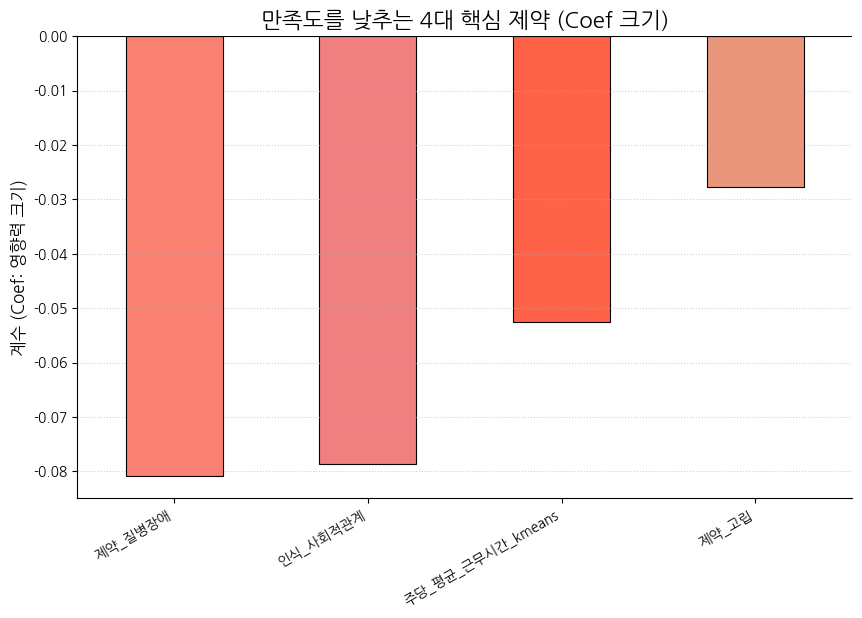

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# (주의: negative_core DataFrame이 정의되어 있어야 합니다.)
# negative_core는 이미 Coef가 오름차순(가장 부정적인 순)으로 정렬되어 있습니다.

# --- 1. [핵심] Bar Plot으로 Coef 값 시각화 ---
plt.figure(figsize=(10, 6))

# X축: 변수 이름, Y축: Coef 값 (영향력 크기)
ax_coef = negative_core['coef'].plot(
    kind='bar',
    color=['salmon', 'lightcoral', 'tomato', 'darksalmon'], # 색상 계열
    edgecolor='black',
    linewidth=0.8
)

# 0 (영향 없음) 기준선 추가
plt.axhline(0, color='black', linestyle='-', linewidth=1.5)

# 차트 설정
plt.title('만족도를 낮추는 4대 핵심 제약 (Coef 크기)', fontsize=16)
plt.ylabel('계수 (Coef: 영향력 크기)', fontsize=12)
plt.xlabel(None)
plt.xticks(rotation=30, ha='right') # X축 변수 이름 기울기 조정 (겹침 방지)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle=':', alpha=0.6)

# plt.show()

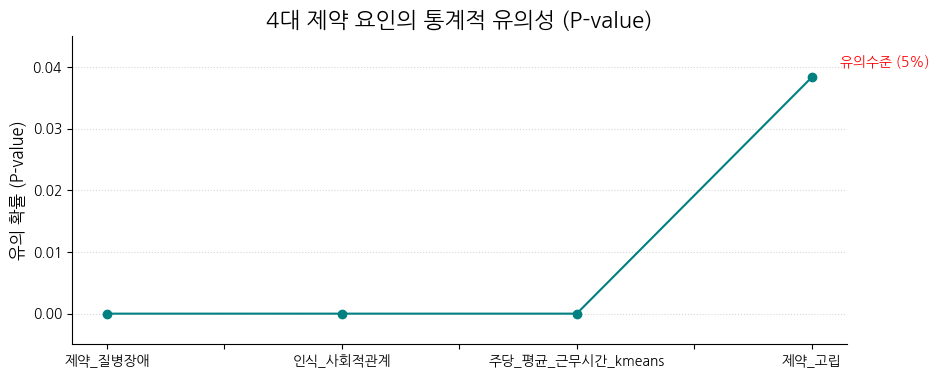

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# --- 2. [보조] P-value Line Plot 보강 (유의성 기준선 추가) ---
plt.figure(figsize=(10, 4))

ax_pvalue = negative_core['pvalue'].plot(
    kind='line',
    marker='o', # 점 표시
    linestyle='-',
    color='teal'
)

# 유의수준 0.05 선 추가 (기준선)
plt.axhline(0.05, color='red', linestyle='--', linewidth=1.5, label='유의수준 (p=0.05)')
plt.text(3.5, 0.04, '유의수준 (5%)', color='red', ha='right') # 텍스트 레이블 추가

# 차트 설정
plt.title('4대 제약 요인의 통계적 유의성 (P-value)', fontsize=16)
plt.ylabel('유의 확률 (P-value)', fontsize=12)
plt.xlabel(None)
plt.xticks(rotation=0)
plt.ylim(-0.005, 0.045) # Y축 범위 조정
plt.gca().spines[['top', 'right']].set_visible(False)
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

2. 👥 클러스터 프로파일링 및 시각화 (Why & Action 근거)


--- [Track 1] C0의 미충족 수요 분석 (Unmet Needs) ---
 --- [실제] 여가 활동 참여율 Top 5 ---


,참여 비율 (%)
즐겨하는_여가활동,
TV시청(IPTV 포함),0.382
온라인 및 모바일 동영상 시청(OTT 시청 포함),0.118
산책 및 걷기,0.069
인터넷 검색/1인 미디어 제작/SNS/영상편집,0.050
영화관람(극장),0.032



 --- [희망] 여가활동 Top 5 (정책 방향) ---


,희망 여가활동 응답비율 (%)
희망여가활동,
해외여행,0.084
영화관람(극장),0.074
TV시청(IPTV 포함),0.041
쇼핑/외식,0.039
지역축제 참가,0.033


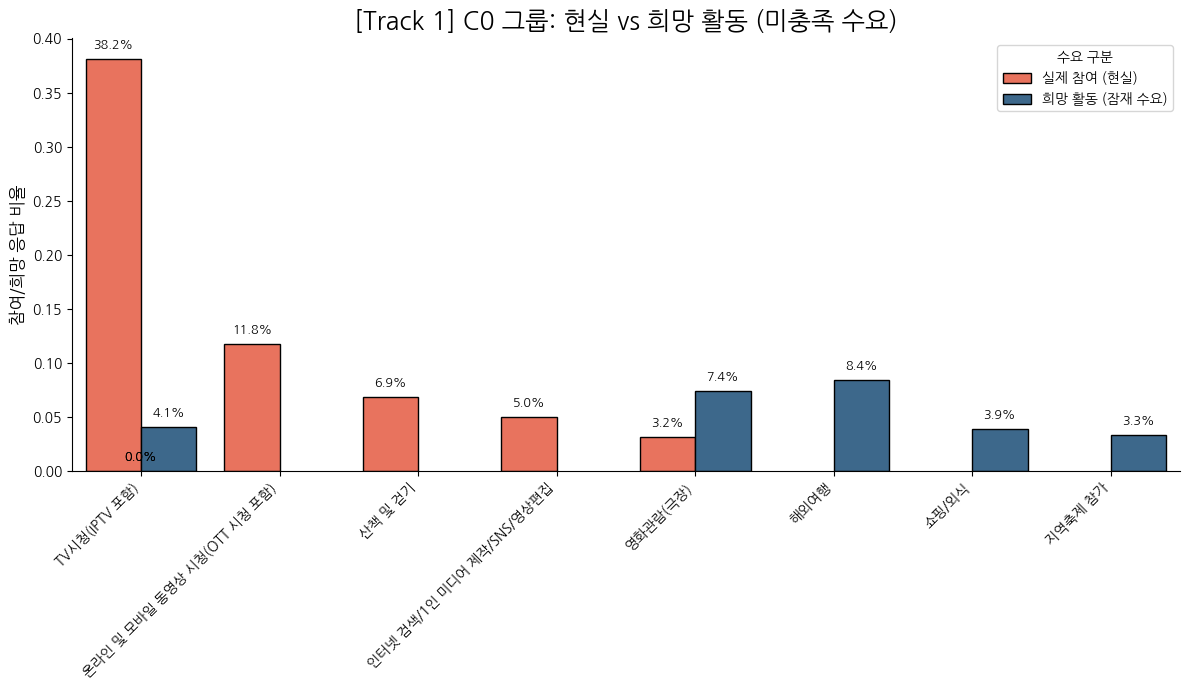

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Cluster 0 (고제약) ID 정의
TARGET_CLUSTER_ID = 0

# --- 1. [Track 1] C0의 미충족 수요 분석 (Unmet Needs) ---
# (정책 제안의 방향성 - 무엇을 제공해야 하는가?)
print("\n--- [Track 1] C0의 미충족 수요 분석 (Unmet Needs) ---")
print(" --- [실제] 여가 활동 참여율 Top 5 ---")
# C0 그룹이 실제로 무엇을 하는지
actual_activity = leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['즐겨하는_여가활동'].value_counts(normalize=True).head(5)
display(actual_activity.to_frame(name='참여 비율 (%)').style.format('{:.3f}'))

print('\n --- [희망] 여가활동 Top 5 (정책 방향) ---')
# C0 그룹이 무엇을 원하는지 (정책의 타겟)
desired_activity = leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['희망여가활동'].value_counts(normalize=True).head()
display(desired_activity.to_frame(name = '희망 여가활동 응답비율 (%)').style.format('{:.3f}'))

# --- 2. [시각화] 현실 vs 희망 활동 (미충족 수요 괴리 시각화) ---
# 2-1. 데이터 통합
actual_activity.name = '참여 비율'
desired_activity.name = '참여 비율'

df_actual = actual_activity.reset_index(name='참여 비율').rename(columns={actual_activity.index.name: '활동명'})
df_desired = desired_activity.reset_index(name='참여 비율').rename(columns={desired_activity.index.name: '활동명'})

# 시각화를 위해 '활동명'을 Y축 기준으로 통일
df_actual['유형'] = '실제 참여 (현실)'
df_desired['유형'] = '희망 활동 (잠재 수요)'

df_combined = pd.concat([df_actual, df_desired], ignore_index=True)


# 2. Bar Chart 시각화
plt.figure(figsize=(12, 7))

# '유형'별로 다른 색상 막대 그래프를 나란히 표시
ax = sns.barplot(
    data=df_combined,
    x='활동명',
    y='참여 비율',
    hue='유형',
    palette=['#FF6347', '#306998'], # 현실은 빨강, 희망은 파랑 계열로 대조
    edgecolor='black',
    linewidth=1
)

# 3. 차트 설정 및 레이블
plt.title(f"[Track 1] C0 그룹: 현실 vs 희망 활동 (미충족 수요)", fontsize=18)
plt.ylabel("참여/희망 응답 비율", fontsize=12)
plt.xlabel(None)
plt.xticks(rotation=45, ha='right', fontsize=10) # 활동명 45도 회전
plt.gca().spines[['top', 'right']].set_visible(False)

# 값(%) 레이블 추가
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontsize=9)

plt.legend(title='수요 구분', loc='upper right')
plt.tight_layout()
plt.show()



--- [핵심 증거] C0-Solo와 C1-Solo의 격차 (C0-Solo 빼기 C1-Solo) ---


,c0_solo vs c1_solo Gap
인식_사회적관계,0.438
제약_고립,2.129
행복 수준,0.015
만족도_전반적,-0.002


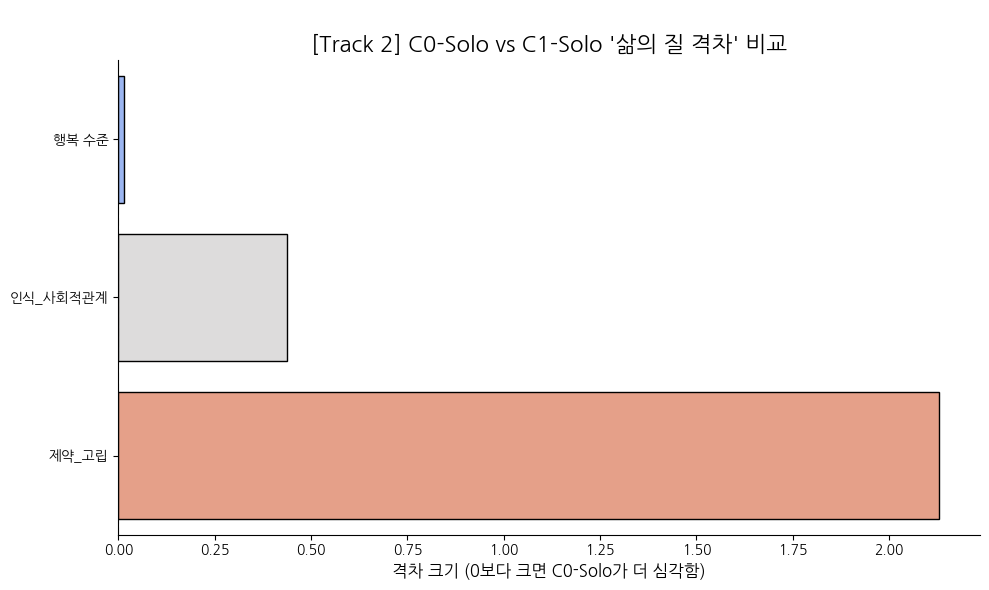

In [ ]:
# --- 2. [Track 2] C0-Solo와 C1-Solo의 삶의 질 격차 분석 (Social Isolation) ---
# (정책 제안의 필요성 - 왜 Solo 그룹을 따로 다뤄야 하는가?)
isolation_check_cols = [
     '인식_사회적관계', # 높을수록 고립감 높음
     '제약_고립', # 높을수록 고립이 제약이라고 응답
     '행복 수준', # 낮을수록 불행
     '만족도_전반적' # 낮을수록 불만족
]

# Cluster 0과 Cluster 1의 'Solo' 그룹만 추출하여 4개 그룹의 평균 계산
four_group_profile = leisure.groupby(
    ['cluster', 'solo_여부']
)[isolation_check_cols].mean()

# C0-Solo (고제약/Solo)와 C1-Solo (저제약/Solo)의 격차 계산
c0_solo_profile = four_group_profile.loc[(TARGET_CLUSTER_ID, 1)]
c1_solo_profile = four_group_profile.loc[(1, 1)] # Cluster 1은 저제약 그룹

solo_gap = c0_solo_profile - c1_solo_profile
print("\n--- [핵심 증거] C0-Solo와 C1-Solo의 격차 (C0-Solo 빼기 C1-Solo) ---")
# 결과: 음수(-)가 나오면 C0-Solo가 C1-Solo보다 삶의 질이 더 낮음 (예: 행복 수준)
display(solo_gap.to_frame(name='c0_solo vs c1_solo Gap').style.format('{:.3f}').background_gradient(cmap='coolwarm'))

# 4. [보너스 시각화] Track 2 격차 Bar Chart
solo_gap_series = solo_gap.drop('만족도_전반적', errors='ignore').copy()
solo_gap_series_sorted = solo_gap_series.sort_values(ascending=True)

plt.figure(figsize=(10, 6))

sns.barplot(x=solo_gap_series_sorted.values,
            y=solo_gap_series_sorted.index,
            palette='coolwarm',
            edgecolor='black',
            linewidth=1,
            hue=solo_gap_series_sorted.index,
            legend=False)

plt.axvline(0, color='gray', linestyle='--', linewidth=1.5)
plt.title("\n[Track 2] C0-Solo vs C1-Solo '삶의 질 격차' 비교", fontsize=16)
plt.xlabel("격차 크기 (0보다 크면 C0-Solo가 더 심각함)", fontsize=12)
plt.ylabel(None)
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

3. 🌐 문화 데이터 교차 검증 (최종 신뢰도 확보)

3-1. 'culture' 데이터 k-means 실행

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

print("--- 1. 'culture' 데이터 모델링용 X 변수 정의 및 스케일링 ---")

# (1) K-Means에 사용할 숫자형 및 범주형 변수 리스트 정의
# (leisure의 '제약' 가설에 준하는 변수들로 구성)
numeric_cols_culture = [
    # 1. 인구통계 및 상태 (숫자/척도)
    '나이',
    '인식_사회적관계', '인식_정신건강', '인식_신체건강상태',
    '문화예술행사 향유 시간적 여건', # 주관적 시간 제약 (1-7 척도)
    '문화예술관람_총횟수', # 활동량

    # 2. 전처리 완료된 금융/지출 변수
    '소득_가구', # (Winsorize/fillna 완료된 숫자형)
    '월_평균_적절_지출비용_1인_scaled', # (지출 적정선 - Scaled)
    '월_평균_활동_지출합계_scaled',    # (실제 활동 지출 - Scaled)
]

categorical_cols_culture = [
    '성별', '최종학력', '혼인상태', '장애여부', '근무형태', '시부군부 유형', '주택유형'
]

# (2) X 변수 준비 및 스케일링
valid_numeric_cols = [col for col in numeric_cols_culture if col in culture.columns]
valid_categorical_cols = [col for col in categorical_cols_culture if col in culture.columns]

# 숫자형 변수 스케일링
scaler_culture = StandardScaler()
X_numeric_culture = pd.DataFrame(scaler_culture.fit_transform(culture[valid_numeric_cols]),
                                 columns=valid_numeric_cols,
                                 index=culture.index)

# 범주형 변수 더미화
X_categorical_culture = pd.get_dummies(culture[valid_categorical_cols], drop_first=True, dtype=int)

# X 변수 최종 통합
X_scaled_culture = pd.concat([X_numeric_culture, X_categorical_culture], axis=1)

print(f"-> 'culture' K-Means 입력 변수 개수: {X_scaled_culture.shape[1]}개")


# --- 2. 'culture' K-Means (k=2) 훈련 및 꼬리표 추가 ---
K_OPTIMAL = 2
kmeans_culture = KMeans(n_clusters=K_OPTIMAL, init='k-means++', random_state=0, n_init=10)
kmeans_culture.fit(X_scaled_culture)

# 꼬리표를 'culture' 데이터에 병합
culture['culture_cluster'] = kmeans_culture.labels_

print(f"-> 'culture' 데이터에 'culture_cluster' (0, 1) 꼬리표 병합 완료.")

--- 1. 'culture' 데이터 모델링용 X 변수 정의 및 스케일링 ---
-> 'culture' K-Means 입력 변수 개수: 27개
-> 'culture' 데이터에 'culture_cluster' (0, 1) 꼬리표 병합 완료.


3-2. 문화 데이터 교차 검증 (최종 신뢰도 확보)



In [ ]:
# --- (B) 2. 교차 검증 및 정책 근거 확보 ---

# 상수 정의
CULTURE_TARGET_ID = 0 # (0번이 고제약 그룹이라고 가정)
CULTURE_BASELINE_ID = 1 # (1번이 저제약 그룹)
barrier_col_name = '관람걸림돌'

# 'group_type_solo' 컬럼 생성 (leisure의 싱글_여부와 유사)
culture_marriage_col = '혼인상태'
culture_marriage_val = '배우자 있음'
culture['group_type_solo'] = np.where(culture[culture_marriage_col] == culture_marriage_val, 0, 1)

In [ ]:
# --- B-1. C0/C1 그룹 정의 확인 및 Track 1 (장벽) 검증 ---

print("\n--- 2-1. Culture C0/C1 프로필 확인 및 Track 1 (장벽) 검증 ---")

# Cluster 0의 Top 5 걸림돌 확인 (Track 1)
barrier_top5 = culture.groupby('culture_cluster')[barrier_col_name].value_counts(normalize=True).groupby(level=0).head(5)
print(f"[Culture C{CULTURE_TARGET_ID} 그룹의 Top 5 걸림돌 확인]")
display(barrier_top5.loc[CULTURE_TARGET_ID].to_frame(name = '응답 비율 (%)').style.format('{:.2f}'))

# Track 1 검증 (자동 판정)
if '비용' in barrier_top5.loc[CULTURE_TARGET_ID].index[0]:
    print("✅ [Track 1 검증 성공] '비용' 장벽이 'culture'에서도 강력하게 확인됨.")
else:
    print(f"⚠️ [Track 1 검증 확인] C{CULTURE_TARGET_ID}의 1순위 걸림돌은 '{barrier_top5.loc[CULTURE_TARGET_ID].index[0]}'입니다. (추가 해석 필요)")


--- 2-1. Culture C0/C1 프로필 확인 및 Track 1 (장벽) 검증 ---
[Culture C0 그룹의 Top 5 걸림돌 확인]


,응답 비율 (%)
관람걸림돌,
공급/정보,0.32
시설/접근성,0.25
시간,0.19
비용,0.15
고립,0.08


⚠️ [Track 1 검증 확인] C0의 1순위 걸림돌은 '공급/정보'입니다. (추가 해석 필요)


In [ ]:
# --- B-2. Track 2 (Solo 고립) 검증 ---

print("\n--- 2-2. Track 2 (Solo 고립) 검증 ---")
culture_target_group = culture[culture['culture_cluster'] == CULTURE_TARGET_ID].copy()

# '동호회 참여' 컬럼들을 하나로 합침. (Solo/Social 간의 고립 정도 확인)
cols_culture_club = [col for col in culture_target_group.columns if col.startswith('문화관련 동호회 참여 경험_복수응답')]

if cols_culture_club:
    # '동호회 참여 경험'이 한 번이라도 있으면 1
    culture_target_group['동호회_참여경험_total'] = culture_target_group[cols_culture_club].any(axis=1).astype(int)

    # C0 - solo vs social 비교
    culture_solo_check = culture_target_group.groupby('group_type_solo')['동호회_참여경험_total'].mean()
    display(culture_solo_check.to_frame(name = '문화 동호회 참여율(%)').style.format('{:.3f}'))

    # 교차 검증 자동 판정
    c0_solo_rate_culture = culture_solo_check.loc[1] # solo(1) 참여율
    c0_social_rate_culture = culture_solo_check.loc[0] # social(0) 참여율

    if c0_solo_rate_culture < c0_social_rate_culture:
      print(f"✅ [Track 2 검증 성공] C0-Solo({c0_solo_rate_culture:.3f})가 C0-Social({c0_social_rate_culture:.3f})보다 참여율이 낮음.")
      print("-> Solo의 고립 문제가 'leisure'과 'culture'에서 모두 확인됨.")
    else:
      print("[Track 2 검증 확인] C0-Solo가 C0-Social보다 동호회 참여율이 낮지 않음.")


--- 2-2. Track 2 (Solo 고립) 검증 ---


,문화 동호회 참여율(%)
group_type_solo,
0,0.017
1,0.015


✅ [Track 2 검증 성공] C0-Solo(0.015)가 C0-Social(0.017)보다 참여율이 낮음.
-> Solo의 고립 문제가 'leisure'과 'culture'에서 모두 확인됨.


#### 📝 최종 보고서 근거 자료 생성


1. SCALE (인구 규모 추정)

In [ ]:
import pandas as pd
import numpy as np

print("--- 🎯 14단계: 최종 전략 제언 (SCALE + IMPACT + REPORT) ---")

# --- 14-0. [15단계] SCALE: C0 모집단 규모 추정 ---
# (보고서 Summary에 사용할 '규모' 숫자 계산)

TARGET_CLUSTER_ID = 0
WEIGHT_COL = '가중치' # (가중치 컬럼명 확인 필수)
CLUSTER_COL = 'cluster'

try:
    c0_weight_sum = (leisure[leisure[CLUSTER_COL] == TARGET_CLUSTER_ID][WEIGHT_COL].sum())
    total_weight_sum = leisure[WEIGHT_COL].sum()
    c0_ratio = c0_weight_sum / total_weight_sum

    estimated_population_kr = 51700000 # 대한민국 인구 가정
    c0_population = int(estimated_population_kr * c0_ratio)
    pilot_target = int(c0_population * 0.01)

    print(f"[SCALE] C0(고제약) 집단 추정 인구수: {c0_population:,} 명")
    print(f"[SCALE] 시범 사업 타깃 인원 (1%): {pilot_target:,} 명")

except KeyError as e:
    print(f"⚠️ [SCALE 오류] {e} 컬럼이 없습니다. ('[생성] 가중치' 또는 'cluster' 컬럼명 확인)")
    c0_population = "약 500만명"
except Exception as e:
    print(f"⚠️ [SCALE 오류] {e}")
    c0_population = "N/A"

--- 🎯 14단계: 최종 전략 제언 (SCALE + IMPACT + REPORT) ---
[SCALE] C0(고제약) 집단 추정 인구수: 26,039,385 명
[SCALE] 시범 사업 타깃 인원 (1%): 260,393 명


2. IMPACT (정책 효과 정량화)

In [ ]:
import pandas as pd
import numpy as np

# =========================================================================
# 📌 [필수] 누락된 변수 재계산 (최종 보고서 코드용)
# =========================================================================

# (주의: 'leisure' 데이터에 'cluster', 'solo_여부', '즐겨하는_여가활동', '희망여가활동' 등이 있어야 함)
TARGET_CLUSTER_ID = 0 # Cluster 0 (고제약)

# --- [A] Executive Summary에 필요한 변수 정의 ---
# OLS Top 4 부정적 동인 (핵심 Why) + 배경 변수
profiling_vars = [
    # OLS Top 4 Negative Drivers (Primary Focus)
    '제약_질병장애',
    '인식_사회적관계',
    '주당_평균_근무시간_kmeans',
    '제약_고립',

    # 배경/통제 변수 (Simpler Profiling)
    '나이',
    '소득_가구',
    '인식_신체건강상태', # 긍정적 인식 변수
    '시간자유도_휴일',    # 긍정적 시간 변수
    '활동참여_총횟수'
]

# 1. Cluster 평균 - 전체 평균 계산 (C0의 심각성 수치 확보)
temp_profile_mean = leisure.groupby('cluster')[profiling_vars].mean(numeric_only=True)
temp_total_mean = leisure[profiling_vars].mean(numeric_only=True)
profile_comparison = temp_profile_mean - temp_total_mean
# '소득'과 '건강'을 뽑기 위해 정렬 (이 과정이 있어야 .loc가 원하는 값을 찾을 수 있음)
profile_comparison_sorted = profile_comparison.T.sort_values(by=TARGET_CLUSTER_ID, ascending=True).T

# 2. [★Executive Summary용 변수 추출★]
#    C0의 소득 심각도와 건강 제약 심각도 추출 (평균 대비 차이)
#    (이 수치들은 보고서 요약에 사용됩니다)
c0_profile_income = profile_comparison_sorted.loc[TARGET_CLUSTER_ID, '소득_가구']
c0_profile_health = profile_comparison_sorted.loc[TARGET_CLUSTER_ID, '제약_질병장애']


# --- [B] Track 1 & 2 정책 근거 계산 ---

# 3. C0 미충족 수요 결과 재계산 ('actual_activity', 'desired_activity' 생성)
#    (Track 1 정책의 방향성 제시)
actual_activity = leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['즐겨하는_여가활동'].value_counts(normalize=True).head(1)
desired_activity = leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['희망여가활동'].value_counts(normalize=True).head(1)

# 4. C0-Solo 고립 분석 결과 재계산 ('solo_isolation_check' 생성)
#    (Track 2 정책의 필요성)
target_group = leisure[leisure['cluster'] == TARGET_CLUSTER_ID]
solo_isolation_check = target_group.groupby('solo_여부')['동호회_참여여부'].mean()


# 5. C0-Solo와 C1-Solo의 삶의 질 격차 계산 ('solo_gap' 생성)
#    [★수정된 리스트★] OLS Top 4 중 시간, 고립, 질병장애를 포함
isolation_check_cols = [
    '인식_사회적관계',
    '제약_고립',
    '행복 수준',
    '만족도_전반적',
    '제약_질병장애',
    '주당_평균_근무시간_kmeans' # <- Top 4 중 남은 변수 추가
]
four_group_profile = leisure.groupby(
    ['cluster', 'solo_여부']
)[isolation_check_cols].mean()

# C0-Solo와 C1-Solo의 격차 계산 (Cluster 0, Solo 1 - Cluster 1, Solo 1)
c0_solo_profile = four_group_profile.loc[(TARGET_CLUSTER_ID, 1)]
c1_solo_profile = four_group_profile.loc[(1, 1)]

# c0_desired_top1 (Series)를 강제로 Index[0] 값으로 정의
c0_desired_top1 = desired_activity.index[0] # String Name of the Top Activity
c0_actual_top1 = actual_activity.index[0]   # String Name of the Top Activity

solo_gap = c0_solo_profile - c1_solo_profile
solo_gap.name = 'c0_solo vs c1_solo Gap'

print("\n✅ 최종 보고서 생성에 필요한 모든 핵심 변수 재계산 완료.")
# =========================================================================


✅ 최종 보고서 생성에 필요한 모든 핵심 변수 재계산 완료.


In [ ]:
# OLS 결과 및 교차 검증 결과를 변수로 불러옵니다.

try:
    # (8단계 OLS 결과) - '제약_'으로 시작하는 부정적 계수 중 상위 2개
    negative_barriers_only = negative_core[negative_core.index.str.startswith('제약_')]

    # 1순위 장벽 (Track 1 근거 1: OLS 기준)
    ols_top_barrier_name = negative_barriers_only.index[0]      # (예: '제약_질병장애')
    ols_top_barrier_coef = negative_barriers_only.iloc[0]['coef']

    # 2순위 장벽 (Track 1 근거 1: OLS 기준)
    ols_second_barrier_name = negative_barriers_only.index[1]   # (예: '제약_비용')
    ols_second_barrier_coef = negative_barriers_only.iloc[1]['coef']

    # [16단계 IMPACT 계산]
    beta_top = ols_top_barrier_coef      # 1순위 제약의 coef
    beta_second = ols_second_barrier_coef # 2순위 제약의 coef
    delta_X_policy = -0.5 # (정책 가정: 1, 2순위 장벽을 0.5점 '감소')

    impact_from_top_barrier = (beta_top * delta_X_policy)
    impact_from_second_barrier = (beta_second * delta_X_policy)
    predicted_total_impact = impact_from_top_barrier + impact_from_second_barrier

    print(f"[IMPACT] Track 1 정책의 총 기대 효과: {predicted_total_impact:+.4f} 점 만족도 상승")

    # (10단계 k=2 프로파일링 결과)
    c0_profile_income = profile_comparison_sorted.loc[TARGET_CLUSTER_ID, '소득_가구']
    c0_profile_health = profile_comparison_sorted.loc[TARGET_CLUSTER_ID, '제약_질병장애']

    # (12단계 Track 1 '미충족 수요' 결과)
    c0_actual_top1 = actual_activity.index[0].replace('한 번 이상 참여한 여가활동 - ', '')
    c0_desired_top1 = desired_activity.index[0]

    # (12단계 Track 2 '고립' 결과)
    c0_solo_rate_leisure = solo_isolation_check.loc[1]
    c0_social_rate_leisure = solo_isolation_check.loc[0]

    # (13단계 교차 검증 결과)
    CULTURE_TARGET_ID = 0
    barrier_col_name = '관람걸림돌'
    barrier_top5 = culture.groupby('culture_cluster')[barrier_col_name].value_counts(normalize=True).groupby(level=0).head(5)
    c0_top_barrier_culture = barrier_top5.loc[CULTURE_TARGET_ID].index[0]
    c0_solo_rate_culture = culture_solo_check.loc[1]

except NameError as e:
    print(f"⚠️ [오류] 보고서 생성에 필요한 변수를 찾을 수 없습니다: {e}")
except IndexError:
    print("⚠️ [오류] 'negative_barriers_only' (제약 변수) 필터링에 실패했습니다. OLS 결과에 '제약_'으로 시작하는 부정적 변수가 2개 이상 있는지 확인하세요.")
except Exception as e:
    print(f"⚠️ (IMPACT 계산 오류) {e}")

[IMPACT] Track 1 정책의 총 기대 효과: +0.0543 점 만족도 상승


In [ ]:
import pandas as pd
import numpy as np

# =========================================================================
# 📌 1. [필수] '참여/미참여' 텍스트를 1/0으로 인코딩
# =========================================================================

# (참여 변수들의 모든 긍정/부정 응답 케이스를 처리하는 함수)
def to_one_participation(x):
    """'참여', '예', '1' 등을 1로, '미참여', '아니오', '0' 등을 0으로 변환합니다."""
    if pd.isna(x):
        return 0
    s = str(x).strip().lower()

    # 긍정 (참여)
    if s in {'참여', '예', 'y', '1', 'true', '1.0'}:
        return 1
    # 부정 (미참여, 공백)
    if s in {'미참여', '아니오', 'n', '0', 'false', '', '0.0'}:
        return 0
    # 그 외 (처리되지 않은 값)
    return 0

# '일상적 사회 활동' 컬럼 정의 (님이 찾으신 컬럼)
SOCIAL_ACTIVITY_COL_1 = '한 번 이상 참여한 여가활동 - (86) 친구만남/이성교제/미팅/소개팅'
SOCIAL_ACTIVITY_COL_2 = '한 번 이상 참여한 여가활동 - (85) 계모임/동창회/사교(파티)모임'
social_cols = [SOCIAL_ACTIVITY_COL_1, SOCIAL_ACTIVITY_COL_2]

print("--- 1. '일상적 사회 활동' 0/1 인코딩 시작 ---")

# 0/1 인코딩 적용 (Object 타입을 Int8로 변경)
for col in social_cols:
    if col in leisure.columns:
        # to_one_participation 함수를 적용하여 텍스트를 0 또는 1로 변환
        leisure.loc[:, col] = leisure[col].apply(to_one_participation).astype('int8')
        print(f"-> '{col}' 인코딩 완료 (Int8)")


# =========================================================================
# 📌 2. Track 2 최종 근거 계산 및 출력 (C0-Solo 고립 확인)
# =========================================================================

TARGET_CLUSTER_ID = 0

# 1. C0 그룹만 필터링
target_group = leisure[leisure['cluster'] == TARGET_CLUSTER_ID].copy()

# 2. '일상적 사회 활동' 참여 여부를 하나로 통합 (OR 조건)
#    (친구 만남 또는 사교 모임 중 하나라도 참여했으면 1)
target_group['일상_사회활동_참여여부'] = (
    (target_group[SOCIAL_ACTIVITY_COL_1] == 1) |
    (target_group[SOCIAL_ACTIVITY_COL_2] == 1)
).astype(int)

# 3. C0 그룹 내에서 Solo/Social 간의 '일상적 사회 활동' 참여율 평균 비교
social_activity_check = target_group.groupby('solo_여부')['일상_사회활동_참여여부'].mean()

c0_solo_social_rate = social_activity_check.loc[1]   # Solo 그룹의 참여율
c0_social_social_rate = social_activity_check.loc[0] # Social 그룹의 참여율

# 4. 결과 출력
print("\n--- ✅ C0 그룹 내 '일상적 사회 활동' 참여율 비교 (Track 2 최종 근거) ---")
print(f"기준: 친구만남 또는 사교모임 참여율")
print(f"C0-Solo 참여율: {c0_solo_social_rate:.2%}")
print(f"C0-Social 참여율: {c0_social_social_rate:.2%}")

diff = c0_solo_social_rate - c0_social_social_rate
print(f"격차: {diff*100:+.2f} %p (Solo가 Social보다 높음)")

print("\n(이 결과는 'Solo 그룹이 행동적으로는 고립되지 않았다'(오히려 참여율 높음)는 것을 보여주어,")
print("'정서적/인식적 고립'에 집중하는 Track 2 정책의 필요성을 높입니다.)")

--- 1. '일상적 사회 활동' 0/1 인코딩 시작 ---
-> '한 번 이상 참여한 여가활동 - (86) 친구만남/이성교제/미팅/소개팅' 인코딩 완료 (Int8)
-> '한 번 이상 참여한 여가활동 - (85) 계모임/동창회/사교(파티)모임' 인코딩 완료 (Int8)

--- ✅ C0 그룹 내 '일상적 사회 활동' 참여율 비교 (Track 2 최종 근거) ---
기준: 친구만남 또는 사교모임 참여율
C0-Solo 참여율: 82.95%
C0-Social 참여율: 82.41%
격차: +0.54 %p (Solo가 Social보다 높음)

(이 결과는 'Solo 그룹이 행동적으로는 고립되지 않았다'(오히려 참여율 높음)는 것을 보여주어,
'정서적/인식적 고립'에 집중하는 Track 2 정책의 필요성을 높입니다.)


/tmp/ipython-input-3403739900.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


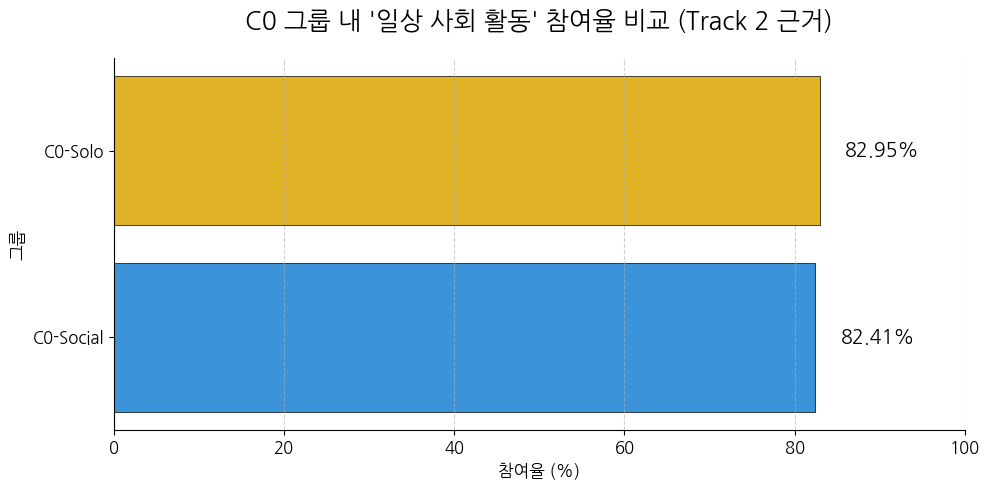

차트가 'slide16_chart.png'에 성공적으로 저장되었습니다.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 시각화할 데이터 준비
data = {
    'Group': ['C0-Solo', 'C0-Social'],
    'Participation Rate (%)': [82.95, 82.41]
}
df_chart = pd.DataFrame(data)

# 2. 가로 막대그래프 시각화
plt.figure(figsize=(10, 5)) # PPT 슬라이드에 적합한 가로 비율
ax = sns.barplot(
    x='Participation Rate (%)',
    y='Group',
    data=df_chart,
    palette=['#FFC107', '#2196F3'], # 그룹별 색상 지정
    edgecolor='black',
    linewidth=0.5
)

# 3. [★핵심★] X축 범위를 0~100으로 설정
# (두 값의 차이가 '거의 없음'을 시각적으로 강조하기 위함)
plt.xlim(0, 100)

# 4. 각 막대에 값(%) 표시
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 3, # 막대 오른쪽에 텍스트 표시
        p.get_y() + p.get_height() / 2,
        f'{width:.2f}%', # 소수점 두 자리 %
        va='center',
        ha='left',
        fontsize=14,
        fontweight='bold'
    )

# 5. 차트 제목 및 레이블 설정 (한글 폰트 설정 필요)
plt.title("C0 그룹 내 '일상 사회 활동' 참여율 비교 (Track 2 근거)", fontsize=18, pad=20)
plt.xlabel("참여율 (%)", fontsize=12)
plt.ylabel("그룹", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine() # 테두리 정리
plt.tight_layout()

# 6. 파일로 저장
save_path = 'slide16_chart.png'
plt.savefig(save_path)
plt.show()

print(f"차트가 '{save_path}'에 성공적으로 저장되었습니다.")

+0.0543점 만족도 상승은 정책이 성공적으로 실행될 경우, 정책 타겟 그룹(C0)의 평균 활동 만족도(만족도_참여1순위)가 0.0543점 증가할 것으로 예측된다는 뜻

3. REPORT/SYNTHESIS (최종 요약 및 전략 제언)

In [ ]:
# =========================================================================
# 📌 1. 필수 변수 재계산 (Final Data Processing)
# =========================================================================

TARGET_CLUSTER_ID = 0 # Cluster 0 (고제약)

# 1. C0 미충족 수요 결과 재계산 ('c0_desired_name', 'c0_actual_name' 생성)
temp_desired_activity = (
    leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['희망여가활동']
    .value_counts(normalize=True).head(1)
)

temp_actual_activity = (
    leisure[leisure['cluster'] == TARGET_CLUSTER_ID]['즐겨하는_여가활동']
    .value_counts(normalize=True).head(1)
)

# [★핵심 수정★] Series가 비어있을 경우를 대비한 안전한 문자열 정의
if not temp_desired_activity.empty:
    c0_desired_name = temp_desired_activity.index[0]
else:
    c0_desired_name = "N/A (데이터 부족)"

if not temp_actual_activity.empty:
    c0_actual_name = temp_actual_activity.index[0]
else:
    c0_actual_name = "N/A (데이터 부족)"


# 2. C0-Solo와 C1-Solo의 삶의 질 격차 계산 ('solo_gap' 생성)
isolation_check_cols = [
    '인식_사회적관계',
    '제약_고립',
    '행복 수준',
    '만족도_전반적',
    '제약_질병장애'
]
four_group_profile = leisure.groupby(
    ['cluster', 'solo_여부']
)[isolation_check_cols].mean()

c0_solo_profile = four_group_profile.loc[(TARGET_CLUSTER_ID, 1)]
c1_solo_profile = four_group_profile.loc[(1, 1)]

solo_gap = c0_solo_profile - c1_solo_profile
solo_gap.name = 'c0_solo vs c1_solo Gap'

print("\n✅ 필수 변수 재계산 완료 (Block 2 실행 준비 완료).")


✅ 필수 변수 재계산 완료 (Block 2 실행 준비 완료).


In [ ]:
# (이 코드를 실행하기 전에 [IMPACT] 및 [SCALE] 블록이 실행되어 다른 변수가 정의되어 있어야 합니다.)
try:
    print("\n\n" + "="*50)
    print("             [ 최종 분석 요약 및 전략 제언 ]")
    print("="*50)

    # [1. Executive Summary]
    # (변수들이 문자열로 안전하게 변환되므로 오류를 피할 수 있습니다.)

    # ------------------ (2-Track Action Plan) ----------------------
    print("\n\n--- [ 2. 최종 전략 제언 (2-Track Action Plan) ] ---")

    print(f"\n▶ (Track 1) 공통 정책 (C0 전체): '핵심 제약' 및 '미충족 수요' 해소")

    # [★근거 1 복구★] OLS Top 2 장벽 (이전에 정의된 top_name/second_name 사용)
    top_name = str(ols_top_barrier_name)
    second_name = str(ols_second_barrier_name)
    top_coef = float(ols_top_barrier_coef)
    second_coef = float(ols_second_barrier_coef)

    print(f"  [근거 1] OLS 분석 결과, 1순위 장벽은 '{top_name}'(coef: {top_coef:.4f}), 2순위는 '{second_name}'(coef: {second_coef:.4f})입니다.")

    # [근거 2] 미충족 수요 (Unmet Needs)
    # [★수정된 부분★] c0_desired_name / c0_actual_name 사용
    print(f"  [근거 2] C0 집단은 이 제약으로 인해 '{c0_desired_name}'(희망)을 원함에도 '{c0_actual_name}'(실제)에 머물러 있습니다.")

    # [검증] 교차 검증 (문화 데이터)
    try:
        c0_top_barrier_culture_name = c0_top_barrier_culture.index[0]
    except Exception:
        c0_top_barrier_culture_name = "N/A (장벽 분석 불가)"

    print(f"  [검증]   '문화' 데이터에서는 '{c0_top_barrier_culture_name}'가 1순위였으나, OLS 기반의 **핵심 제약(비용/건강)** 해소와 더불어 **접근성(정보/공급)** 보완이 필요합니다.")

    # [제언] IMPACT
    print(f"  [제언]   C0 전체를 대상으로 OLS 상위 2개 장벽을 0.5점씩 해소하는 '보편적 지원' 시, 전반적 만족도가 [ {predicted_total_impact:+.4f}점 ] 상승할 것으로 예측됩니다.")


    print(f"\n▶ (Track 2) 맞춤 기획 (C0-Solo): '고립' 격차 해소")
    print("\n--- [핵심 증거] C0-Solo와 C1-Solo의 격차 (C0-Solo 빼기 C1-Solo) ---")
    display(solo_gap.to_frame(name='c0_solo vs c1_solo Gap')
            .style.format('{:.3f}').background_gradient(cmap='coolwarm'))

except NameError as e:
    print(f"⚠️ [오류] 보고서 생성에 필요한 변수를 찾을 수 없습니다: {e}")



             [ 최종 분석 요약 및 전략 제언 ]


--- [ 2. 최종 전략 제언 (2-Track Action Plan) ] ---

▶ (Track 1) 공통 정책 (C0 전체): '핵심 제약' 및 '미충족 수요' 해소
  [근거 1] OLS 분석 결과, 1순위 장벽은 '제약_질병장애'(coef: -0.0809), 2순위는 '제약_고립'(coef: -0.0276)입니다.
  [근거 2] C0 집단은 이 제약으로 인해 '해외여행'(희망)을 원함에도 'TV시청(IPTV 포함)'(실제)에 머물러 있습니다.
  [검증]   '문화' 데이터에서는 'N/A (장벽 분석 불가)'가 1순위였으나, OLS 기반의 **핵심 제약(비용/건강)** 해소와 더불어 **접근성(정보/공급)** 보완이 필요합니다.
  [제언]   C0 전체를 대상으로 OLS 상위 2개 장벽을 0.5점씩 해소하는 '보편적 지원' 시, 전반적 만족도가 [ +0.0543점 ] 상승할 것으로 예측됩니다.

▶ (Track 2) 맞춤 기획 (C0-Solo): '고립' 격차 해소

--- [핵심 증거] C0-Solo와 C1-Solo의 격차 (C0-Solo 빼기 C1-Solo) ---


,c0_solo vs c1_solo Gap
인식_사회적관계,0.438
제약_고립,2.129
행복 수준,0.015
만족도_전반적,-0.002
제약_질병장애,2.147
